In [27]:
library(stringr)
library(dplyr)
library(ggplot2)
library(lubridate)
library(ISOweek)
library(scales)
library(zoo)
library(tidyr)
library(quantreg)
library(splines)
library(pbs)
library(forecast)
require(RcppRoll)
raw_deaths = read.csv("../data/death_nor_07995_20220207.csv", skip=2, stringsAsFactors=FALSE, 
                  fileEncoding="latin1", sep=";")
head(raw_deaths)
weighted_mean = function(x) {
    nas = is.na(x)
    w = c(0.25, 0.5, 0.25)
    if (all(nas)) {
        return(0)
    } else {
        w = w[!nas] / sum(w[!nas])
        return(sum(x[!nas] * w))
    }
}

statistikkvariabel kjønn       alder      uke   X2000 X2001 X2002 X2003 X2004
1 Døde               Begge kjønn Alle aldre Uke 1 1296  901   1027  1039  944  
2 Døde               Begge kjønn Alle aldre Uke 2 1219  967   932   966   954  
3 Døde               Begge kjønn Alle aldre Uke 3 1073  879   918   993   940  
4 Døde               Begge kjønn Alle aldre Uke 4 1044  885   919   896   915  
5 Døde               Begge kjønn Alle aldre Uke 5 978   885   899   887   946  
6 Døde               Begge kjønn Alle aldre Uke 6 941   933   941   862   852  
  X2005 ⋯ X2013 X2014 X2015 X2016 X2017 X2018 X2019 X2020 X2021 X2022
1 870   ⋯ 1004  781   937   870   1006  938   872   862   830   932  
2 842   ⋯ 884   805   977   864   1048  872   829   952   869   878  
3 801   ⋯ 909   830   913   939   928   945   812   837   860   780  
4 834   ⋯ 921   809   930   937   866   857   835   862   852   .    
5 835   ⋯ 909   836   911   881   914   881   889   815   791   .    
6 815   ⋯ 893   817   898   852   823   904   843   796   817   .

In [28]:
deaths = raw_deaths[raw_deaths$alder != "Alle aldre", ]
deaths$alder = as.numeric(str_extract(deaths$alder, "(\\d+)"))
deaths$uke = as.numeric(str_extract(deaths$uke, "(\\d+)"))
deaths = rename(deaths, age = alder)
deaths = rename(deaths, sex = kjønn)
deaths = rename(deaths, week = uke)
deaths$sex = as.factor(deaths$sex)
levels(deaths$sex) = list(b=deaths$sex[1]) # This assumes one gender only (both)
deaths = pivot_longer(deaths, 
                      cols=starts_with("X"), names_to="year", names_prefix="X", 
                      values_to="death")
deaths$year = as.numeric(deaths$year)
deaths$death[deaths$death == "."] = 0 # This is the NA string
deaths$death = as.numeric(deaths$death)
head(deaths)

statistikkvariabel sex age week year death
1 Døde               b   0   1    2000 6    
2 Døde               b   0   1    2001 1    
3 Døde               b   0   1    2002 3    
4 Døde               b   0   1    2003 1    
5 Døde               b   0   1    2004 4    
6 Døde               b   0   1    2005 5

In [29]:
# Read population data
raw_pop = read.csv("../data/pop_nor_07459_20220207.csv", skip=2, stringsAsFactors=FALSE, 
                  fileEncoding="latin1", sep=";")

In [30]:
pop = raw_pop[raw_pop$alder != "Alle aldre", ]
pop$alder = as.numeric(str_extract(pop$alder, "(\\d+)"))
pop = rename(pop, age = alder)
pop = rename(pop, sex = kjønn)
pop$sex = as.factor(pop$sex)
levels(pop$sex) = list(m="Menn", f="Kvinner")
pop = pivot_longer(pop, 
                      cols=starts_with("X"), names_to="year", names_prefix="X", 
                      values_to="pop")
pop$year = as.numeric(pop$year)
pop$pop = as.numeric(pop$pop)
tail(pop)

statistikkvariabel region        sex age year pop
1 Personer           0 Hele landet f   105 2016 37 
2 Personer           0 Hele landet f   105 2017 44 
3 Personer           0 Hele landet f   105 2018 50 
4 Personer           0 Hele landet f   105 2019 52 
5 Personer           0 Hele landet f   105 2020 54 
6 Personer           0 Hele landet f   105 2021 75

In [31]:
# First lets check Gompertz law of mortality
# The ESP age groups
esp_group = cut(deaths$age, c(0,1,seq(5,95, 5), 200), right=FALSE)
esp_groups = levels(esp_group)

gdeaths = deaths %>% group_by(age = esp_group, year, week) %>% summarize(
    death = sum(death)
    )
tail(gdeaths)

`summarise()` has grouped output by 'age', 'year'. You can override using the `.groups` argument.



age      year week death
1 [95,200) 2022 48   0    
2 [95,200) 2022 49   0    
3 [95,200) 2022 50   0    
4 [95,200) 2022 51   0    
5 [95,200) 2022 52   0    
6 [95,200) 2022 53   0

In [32]:
pop_esp_group = cut(pop$age, c(0,1,seq(5,95, 5), 200), right=FALSE)
gpop = pop %>% group_by(age = pop_esp_group, year) %>% summarize(pop=sum(pop))
tail(gpop)

`summarise()` has grouped output by 'age'. You can override using the `.groups` argument.



age      year pop  
1 [95,200) 2016  9419
2 [95,200) 2017  9872
3 [95,200) 2018 10275
4 [95,200) 2019 10420
5 [95,200) 2020 10780
6 [95,200) 2021 11055

In [33]:
weeks = gdeaths$week
weeks[nchar(weeks) == 1] <- paste0("0", weeks[nchar(weeks) == 1])
week_pattern = paste(gdeaths$year, paste("W", weeks, sep=""), 
                   1, sep="-")
gdeaths$date = ISOweek2date(week_pattern)
gdeaths = gdeaths[gdeaths$week != 53,]
head(gdeaths)

age   year week death date      
1 [0,1) 2000 1     6    2000-01-03
2 [0,1) 2000 2     5    2000-01-10
3 [0,1) 2000 3     4    2000-01-17
4 [0,1) 2000 4    10    2000-01-24
5 [0,1) 2000 5     5    2000-01-31
6 [0,1) 2000 6     7    2000-02-07

In [34]:
# we see almost 10% of rows have zero deaths. This must be fixed
merged = merge(gdeaths, gpop, by=c("year", "age"))
merged$end_age = gsub("\\[\\d+,", "", as.character(merged$age), perl=TRUE)
merged$end_age = as.numeric(gsub("\\)", "", as.character(merged$end_age), perl=TRUE)) - 1
merged$end_age[merged$end_age %in% c(199, 200)] = 105
merged$start_age = as.numeric(str_extract(merged$age, "\\d+"))
merged$avg_age = (merged$start_age + merged$end_age) / 2
dim(merged[merged$death==0,])[1] / dim(merged)[1]


[1] 0.09794372

In [35]:
# With a smoother we are down to 3%. This is managable
merged<-arrange(merged, age, date) %>%
       mutate(sdeaths=rollapply(death, 3, weighted_mean, align='center',fill=TRUE))
dim(merged[merged$sdeaths==0,])[1] / dim(merged)[1]
tail(merged)

[1] 0.0294289

year age   week death date       pop   end_age start_age avg_age sdeaths
1 2000 [0,1) 1     6    2000-01-03 59372 0       0         0       1.00   
2 2000 [0,1) 2     5    2000-01-10 59372 0       0         0       5.00   
3 2000 [0,1) 3     4    2000-01-17 59372 0       0         0       5.75   
4 2000 [0,1) 4    10    2000-01-24 59372 0       0         0       7.25   
5 2000 [0,1) 5     5    2000-01-31 59372 0       0         0       6.75   
6 2000 [0,1) 6     7    2000-02-07 59372 0       0         0       6.00

Warning message:
“Removed 30 row(s) containing missing values (geom_path).”


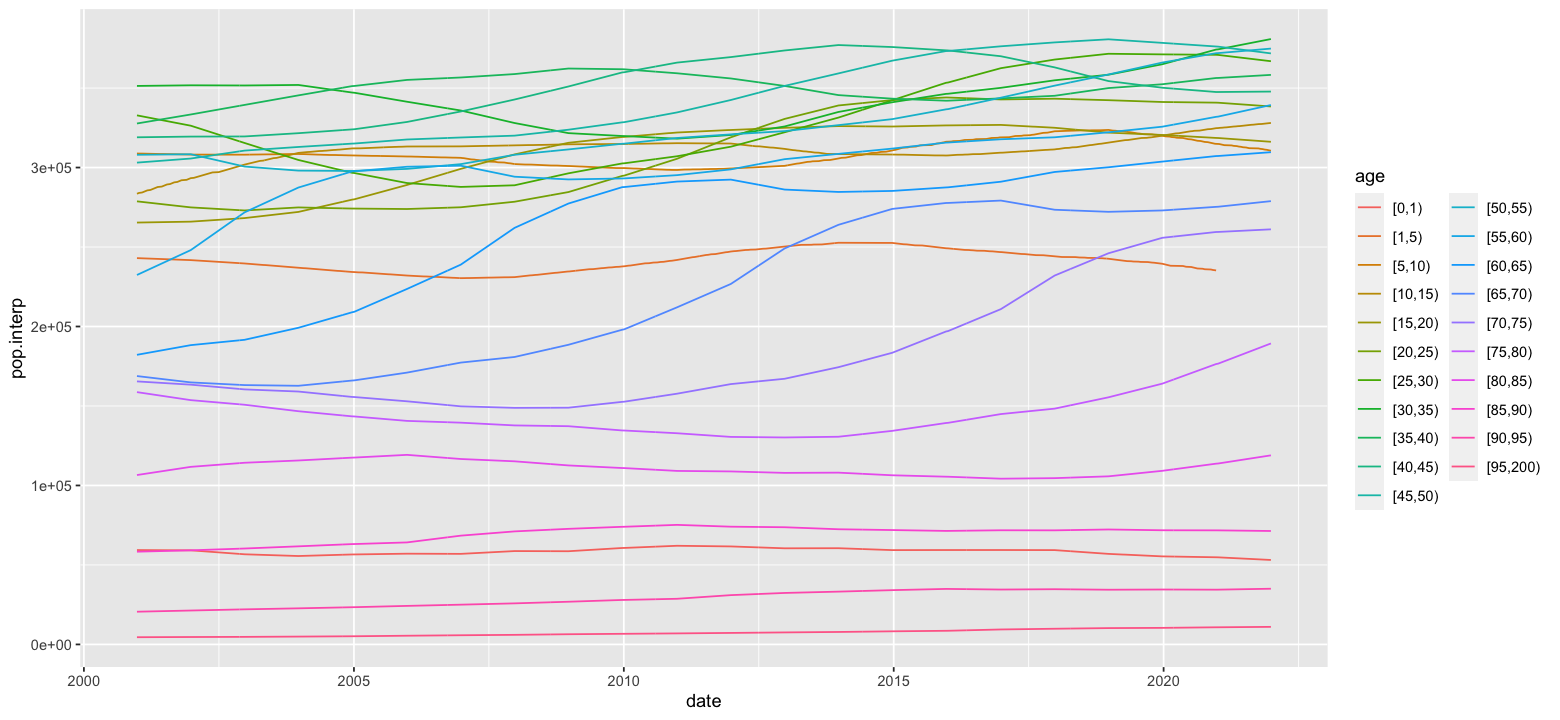

In [295]:
options(repr.plot.width=13, repr.plot.height=6)
merged$pop[merged$week != 52] = NA
merged = merged %>%
  group_by(age) %>%
    arrange(age, date) %>%
    mutate(time=seq(1,n())) %>%
      mutate(pop.interp=approx(time,pop,time)$y) %>%
      select(-time)
# merged[merged$start_age == 0,]$pop.interp
ggplot(merged, aes(date, pop.interp, color=age)) + geom_line()
# plot(merged[merged$start_age == 75,]$date, merged[merged$start_age == 75,]$pop.interp)

In [37]:
merged = subset(merged, sdeaths != 0 & !is.na(merged$pop.interp))
merged$mu = merged$sdeaths / merged$pop.interp
merged$lnmu = log(merged$sdeaths / merged$pop.interp)

head(merged)

year age   week death date       pop   end_age start_age avg_age sdeaths
1 2000 [0,1) 52   6     2000-12-25 59372 0       0         0       4.00   
2 2001 [0,1)  1   1     2001-01-01    NA 0       0         0       4.25   
3 2001 [0,1)  2   9     2001-01-08    NA 0       0         0       5.50   
4 2001 [0,1)  3   3     2001-01-15    NA 0       0         0       4.25   
5 2001 [0,1)  4   2     2001-01-22    NA 0       0         0       3.25   
6 2001 [0,1)  5   6     2001-01-29    NA 0       0         0       4.25   
  pop.interp mu           lnmu     
1 59372.00   6.737183e-05 -9.605284
2 59368.56   7.158671e-05 -9.544601
3 59365.12   9.264700e-05 -9.286714
4 59361.67   7.159502e-05 -9.544485
5 59358.23   5.475231e-05 -9.812691
6 59354.79   7.160332e-05 -9.544369

In [38]:
age_deaths = subset(merged, year < 2020) %>% group_by(avg_age, year) %>% summarize(sdeaths=sum(sdeaths, na.rm=TRUE), pop=pop.interp) %>% distinct()
age_deaths$lnmu = log(age_deaths$sdeaths / age_deaths$pop)
rates = age_deaths %>% dplyr::group_by(avg_age) %>% dplyr::summarise(mean_lnmu=mean(lnmu), sd_lnmu=sd(lnmu, na.rm=TRUE))
rates = rename(rates, age = avg_age)

`summarise()` has grouped output by 'avg_age', 'year'. You can override using the `.groups` argument.



`geom_smooth()` using formula 'y ~ x'



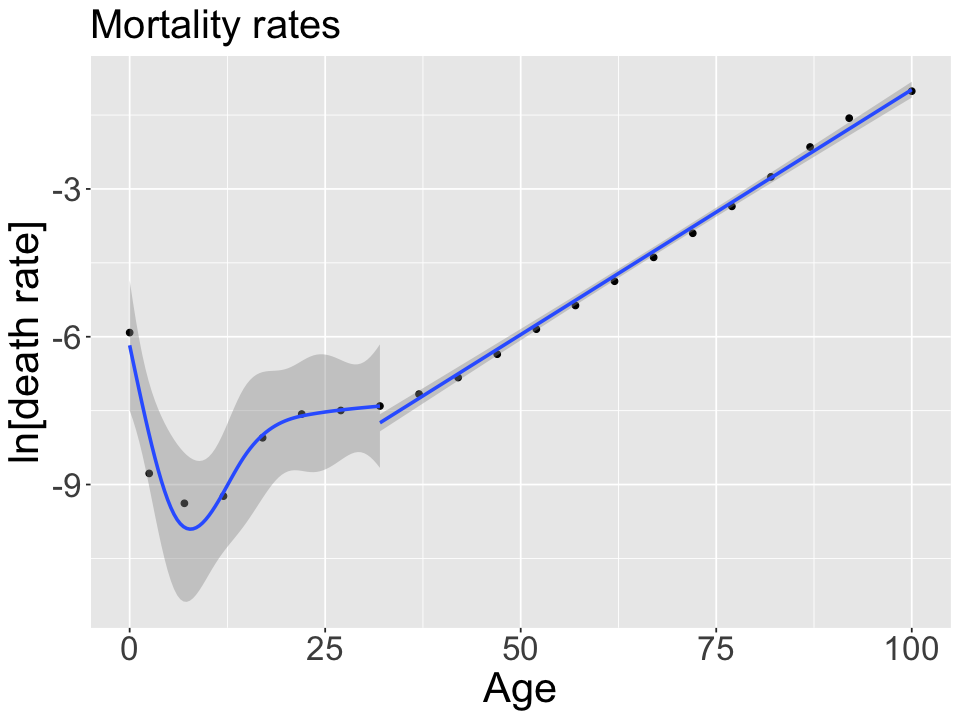

In [39]:
# We see that the relationship is simple after 30 years of age. Before we need to be careful.
options(repr.plot.width=8, repr.plot.height=6)
a = ggplot(rates, aes(age, mean_lnmu, weight=1/sd_lnmu))
a + geom_point() + geom_smooth(data=subset(rates, age > 30), method = "lm", se=TRUE) +
geom_smooth(data=subset(rates, age <= 35), method = "lm", formula=y~ns(x, df=4), se=TRUE) +
labs(x = "Age", y = "ln[death rate]", title="Mortality rates") +
theme(title=element_text(size=20), axis.text=element_text(size=20), axis.title=element_text(size=25))

In [41]:
esp_groups

[1] "[0,1)"    "[1,5)"    "[5,10)"   "[10,15)"  "[15,20)"  "[20,25)" 
 [7] "[25,30)"  "[30,35)"  "[35,40)"  "[40,45)"  "[45,50)"  "[50,55)" 
[13] "[55,60)"  "[60,65)"  "[65,70)"  "[70,75)"  "[75,80)"  "[80,85)" 
[19] "[85,90)"  "[90,95)"  "[95,200)"

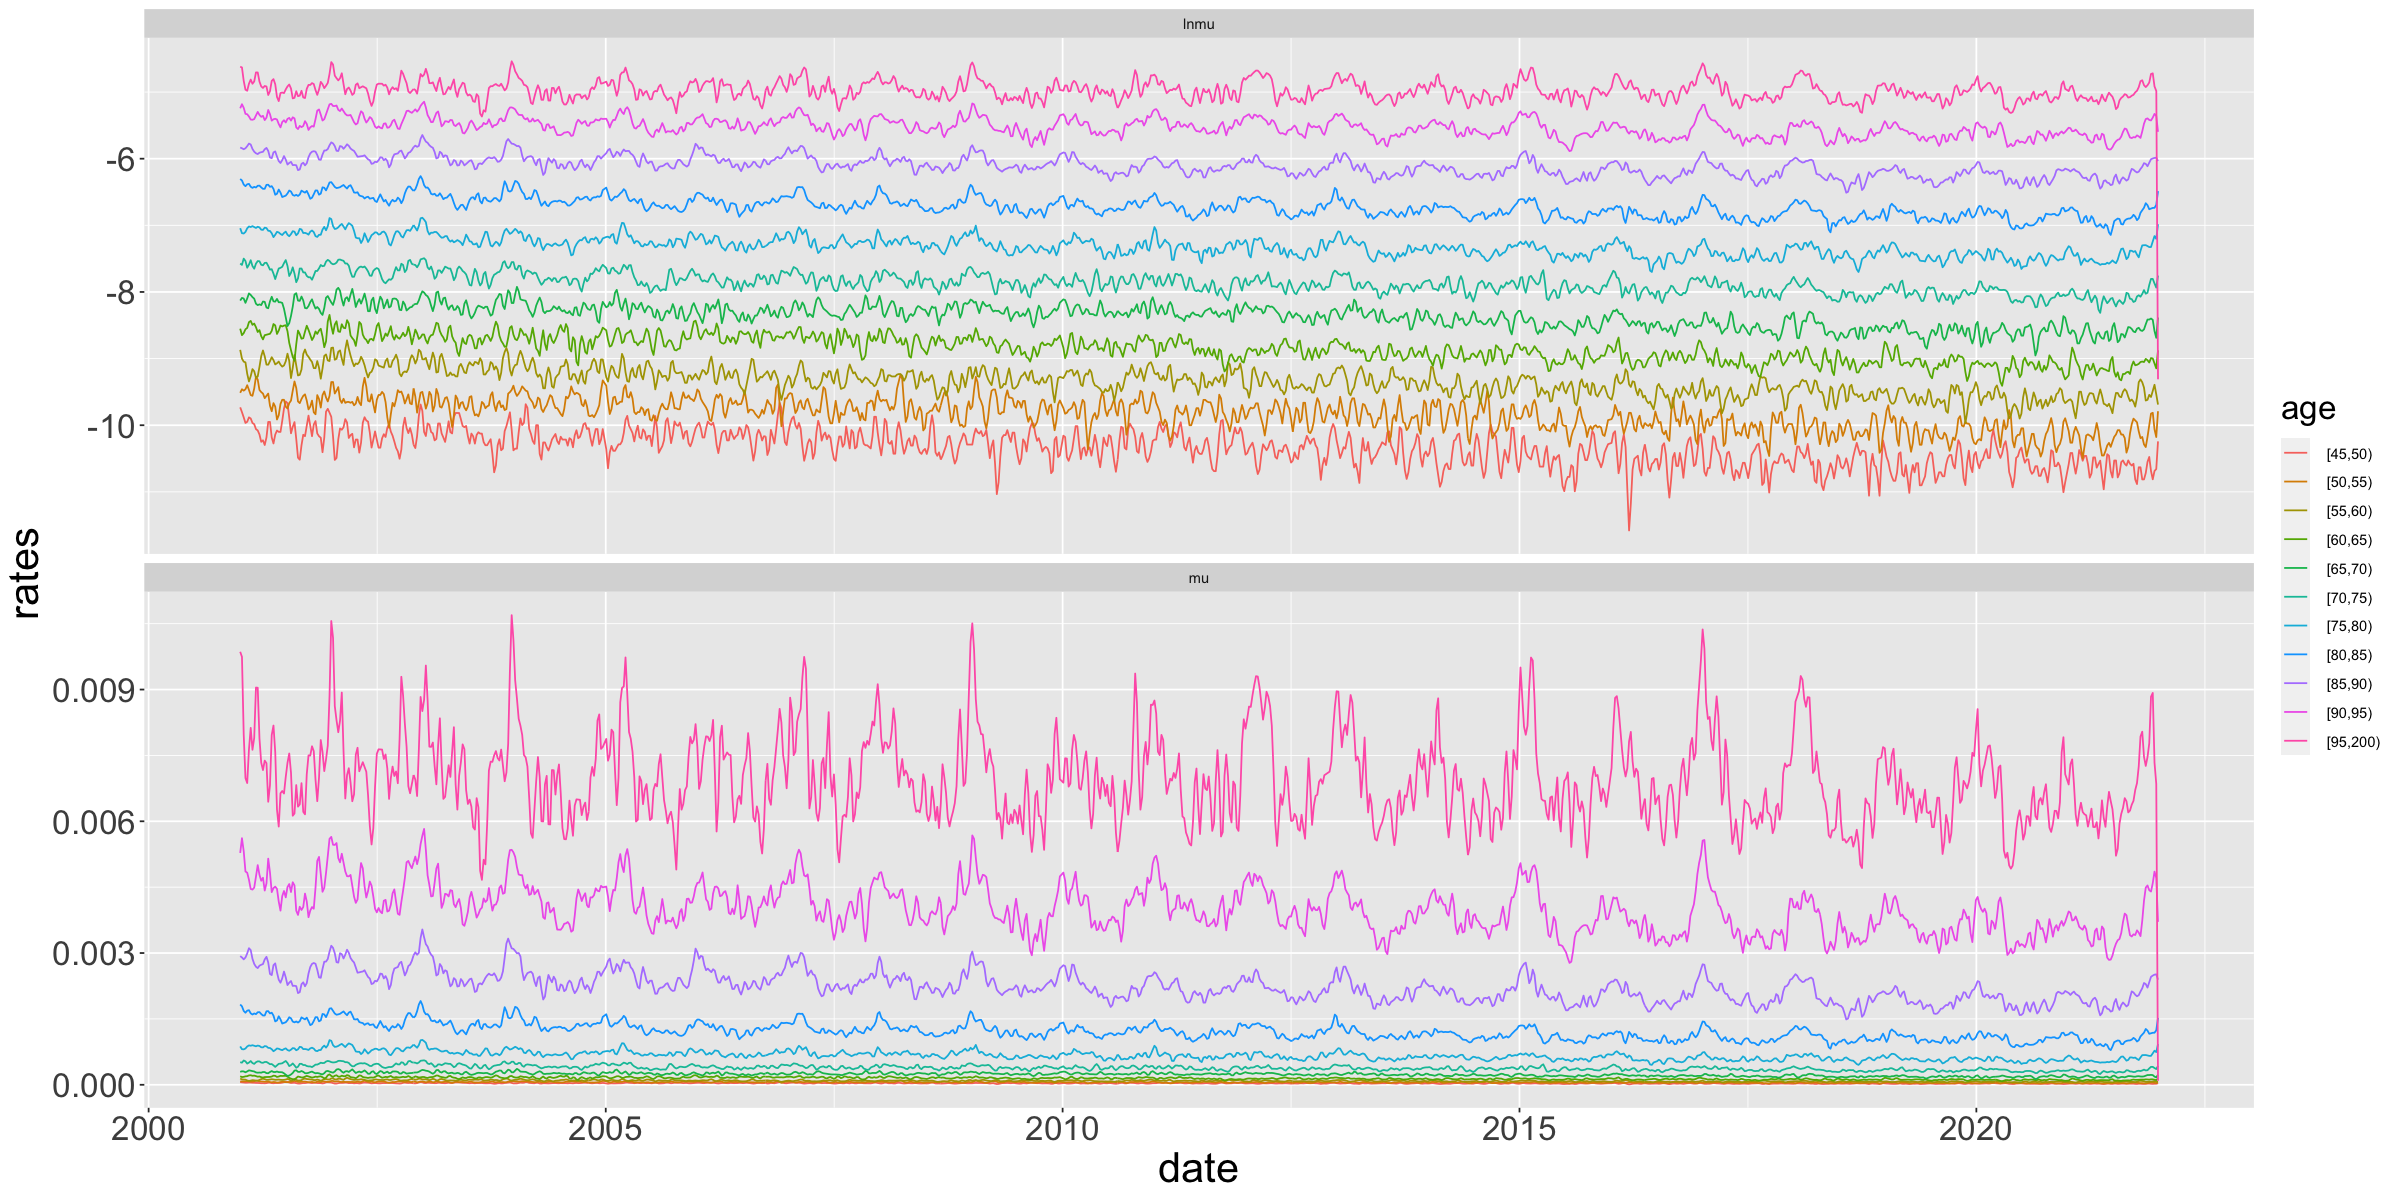

In [42]:
# Plot mortality and log(mortality), notice the changing standard deviation vs age group.
# We can group 65+ together but lower than that is risky.
# We also notice that there is an unrealistic drop the last week of 2021,
# possibly due to data collection being inclomplete.
n_groups = length(esp_groups)
subset = subset(merged, age %in% esp_groups[(n_groups-10):n_groups] & year > 2000)
subset = pivot_longer(subset, c("mu", "lnmu"), values_to="rates", names_to=c("type"))
options(repr.plot.width=20, repr.plot.height=10)
n_groups = length(esp_groups)
a = ggplot(subset, aes(x=date, y=rates, color=age))
a + geom_line() + facet_wrap(~type, scales="free_y", ncol=1) +
theme(title=element_text(size=20), axis.text=element_text(size=20), axis.title=element_text(size=25))

In [58]:
esp_pop = c(1000, 4000, 5500, 5500, 5500, 6000, 6000, 6500, 7000, 
            7000, 7000, 7000, 6500, 6000, 5500, 5000, 4000, 2500, 1500, 800, 200)
esp_pop = data.frame(age=esp_groups, esp_pop=esp_pop)

norm = merge(merged, esp_pop, by="age")
norm$deaths_norm = norm$mu * norm$esp_pop
head(norm)

age   year week death date       pop   end_age start_age avg_age sdeaths
1 [0,1) 2000 52   6     2000-12-25 59372 0       0         0       4.00   
2 [0,1) 2001  1   1     2001-01-01    NA 0       0         0       4.25   
3 [0,1) 2001  2   9     2001-01-08    NA 0       0         0       5.50   
4 [0,1) 2001  3   3     2001-01-15    NA 0       0         0       4.25   
5 [0,1) 2001  4   2     2001-01-22    NA 0       0         0       3.25   
6 [0,1) 2001  5   6     2001-01-29    NA 0       0         0       4.25   
  pop.interp mu           lnmu      esp_pop deaths_norm
1 59372.00   6.737183e-05 -9.605284 1000    0.06737183 
2 59368.56   7.158671e-05 -9.544601 1000    0.07158671 
3 59365.12   9.264700e-05 -9.286714 1000    0.09264700 
4 59361.67   7.159502e-05 -9.544485 1000    0.07159502 
5 59358.23   5.475231e-05 -9.812691 1000    0.05475231 
6 59354.79   7.160332e-05 -9.544369 1000    0.07160332

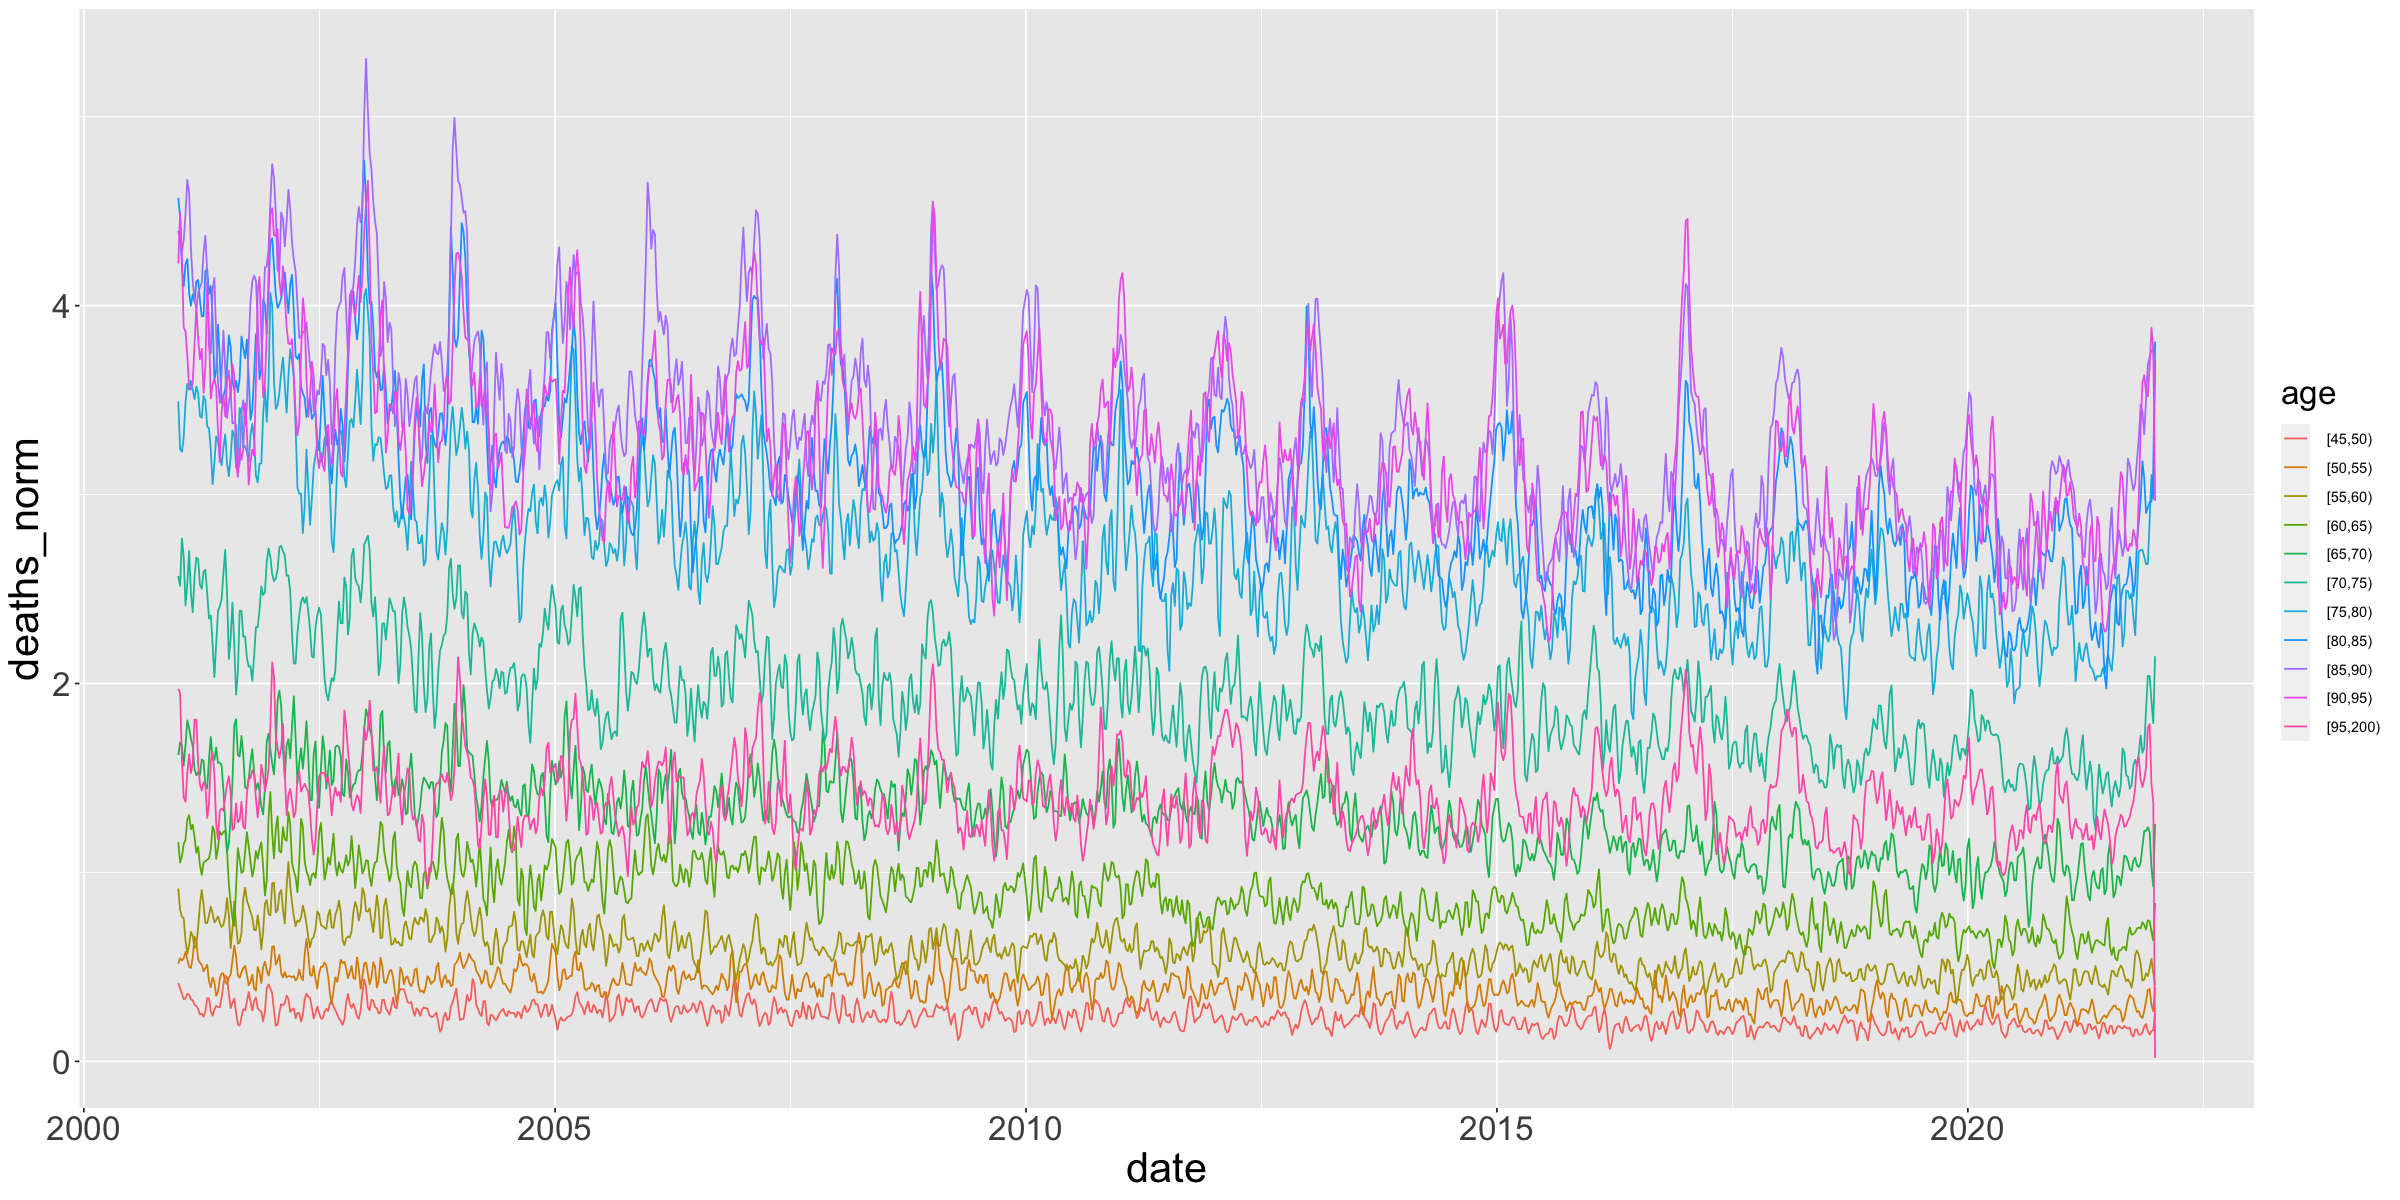

In [49]:
options(repr.plot.width=20, repr.plot.height=10)
n_groups = length(esp_groups)
subset = subset(norm, age %in% esp_groups[(n_groups-10):n_groups] & year > 2000)
a = ggplot(subset, aes(x=date, y=deaths_norm, color=age))
a + geom_line() +
theme(title=element_text(size=20), axis.text=element_text(size=20), axis.title=element_text(size=25))

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.

Smoothing formula not specified. Using: y ~ x



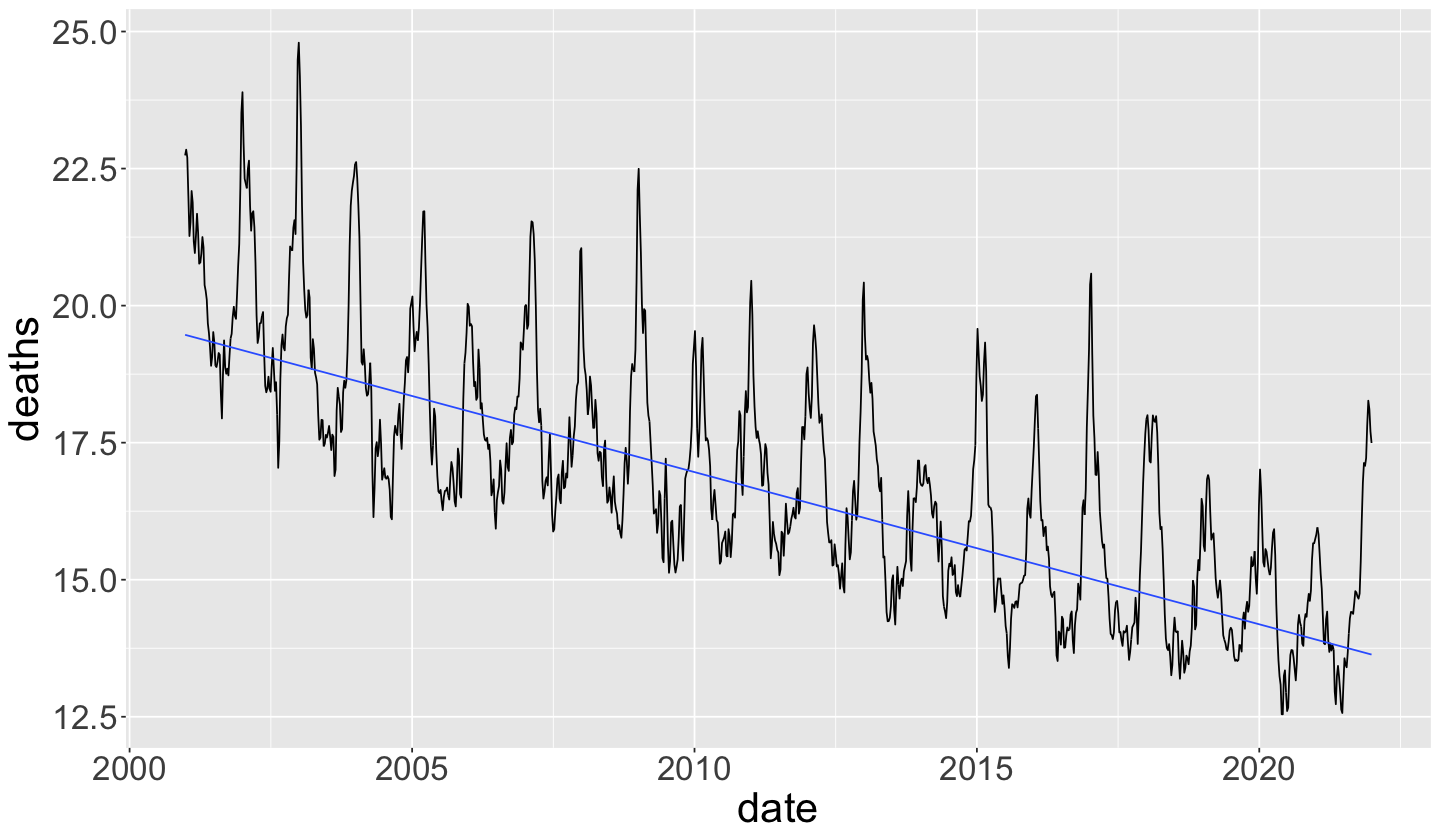

In [280]:
# ESP combined deaths
old_norm = subset(norm, start_age > 64) %>% group_by(date) %>% summarise(deaths=sum(deaths_norm), week=week)
old_norm$days = old_norm$date - old_norm$date[1]
a = ggplot(old_norm, aes(x=date, y=deaths))
a + geom_line() + geom_quantile(quantiles=c(0.5)) + 
theme(title=element_text(size=20), axis.text=element_text(size=20), axis.title=element_text(size=25))


Call: rq(formula = detrended ~ pbs(week, df = df), data = train)

tau: [1] 0.5

Coefficients:
                    coefficients lower bd upper bd
(Intercept)          0.20694     -0.02669  0.40848
pbs(week, df = df)1 -1.26461     -1.71791 -0.84710
pbs(week, df = df)2 -1.07639     -1.31405 -0.68610
pbs(week, df = df)3 -1.06796     -1.34557 -0.77609
pbs(week, df = df)4 -0.45570     -0.84045 -0.07557
pbs(week, df = df)5  2.44629      2.08041  2.86636
pbs(week, df = df)6  2.50879      1.91986  3.06969

[1] "Fraction of observations outside confidence band in pre-2020: 0.036"

[1] "Fraction of observations outside confidence band in 2021: 0.577"

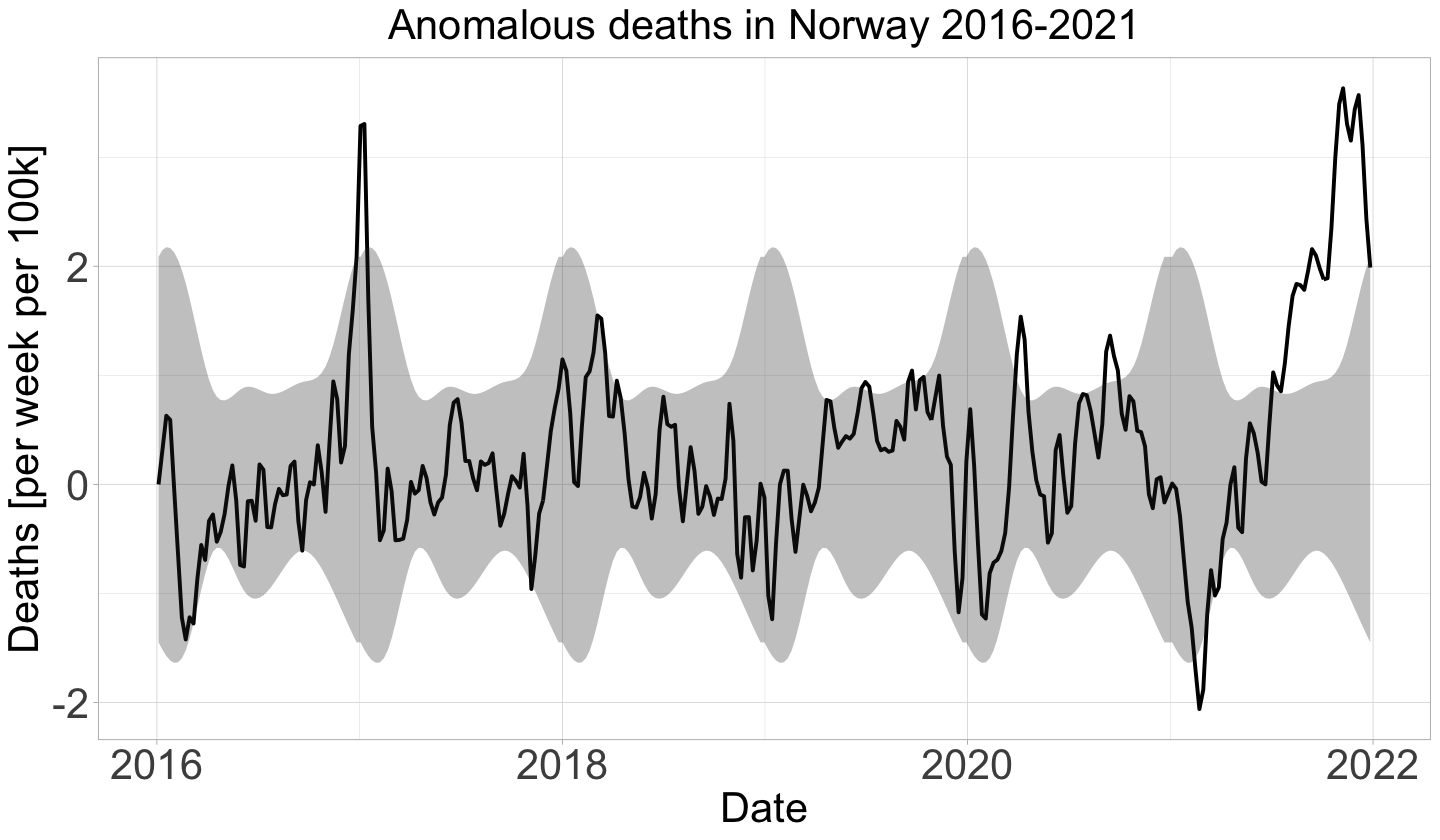

In [386]:

df = 6 # Degrees of freedom for spline fit
start_year = 2012
options(repr.plot.width=12, repr.plot.height=7)
train = subset(old_norm,year(date) < 2020 & year(date) >= start_year) %>% distinct()
all = subset(old_norm,year(date) >= start_year) %>% distinct()
rq.fit = rq(deaths ~ days, data=train)


sigma = sd(rq.fit$res)
# Get detrended and centered with a seasonal trend based on periodic splines with 6 degrees of freedom
all$detrended = all$deaths - predict(rq.fit, newdata=all)
train$detrended = train$deaths - predict(rq.fit, newdata=train)
rq.fit = rq(detrended ~ pbs(week, df=df), data=train)
summary(rq.fit)
all$trend = predict(rq.fit, newdata=all)
train$trend = predict(rq.fit, newdata=train)
train$centered = train$detrended - train$trend
all$centered = all$detrended - all$trend

# Get confidence intervals
rq.fit.low = rq(centered ~ pbs(week, df=df), data=train, tau=0.025)
rq.fit.high = rq(centered ~ pbs(week, df=df), data=train, tau=0.975)
train$centered_high = predict(rq.fit.high, newdata=train)
train$centered_low = predict(rq.fit.low, newdata=train)
all$centered_high = predict(rq.fit.high, newdata=all)
all$centered_low = predict(rq.fit.low, newdata=all)
test = subset(all, year(date) == 2021)
# Test that the residuals are within the confidence band with desired frequency
frac_outside = sum(train$centered < train$centered_low | train$centered > train$centered_high) / nrow(train)
frac_outside_test = sum(test$centered < test$centered_low | test$centered > test$centered_high) / nrow(test)
sprintf("Fraction of observations outside confidence band in pre-2020: %.3f", frac_outside)
sprintf("Fraction of observations outside confidence band in 2021: %.3f", frac_outside_test)
ggplot(subset(all, year(date) > 2015), aes(date, centered)) + 
geom_line(size=1.1) + 
geom_ribbon(aes(ymin=centered_low, ymax=centered_high), alpha=0.3) +
theme_light() +
labs(x = "Date", y = "Deaths [per week per 100k]", title="Anomalous deaths in Norway 2016-2021") +
theme(plot.title=element_text(size=25, hjust=.5), axis.text=element_text(size=25), axis.title=element_text(size=25))


year frac_outside frac_over 
1  2012 0.01886792   0.00000000
2  2013 0.03846154   0.01923077
3  2014 0.03846154   0.00000000
4  2015 0.03921569   0.00000000
5  2016 0.00000000   0.00000000
6  2017 0.05769231   0.03846154
7  2018 0.03773585   0.03773585
8  2019 0.05769231   0.05769231
9  2020 0.13725490   0.13725490
10 2021 0.57692308   0.48076923

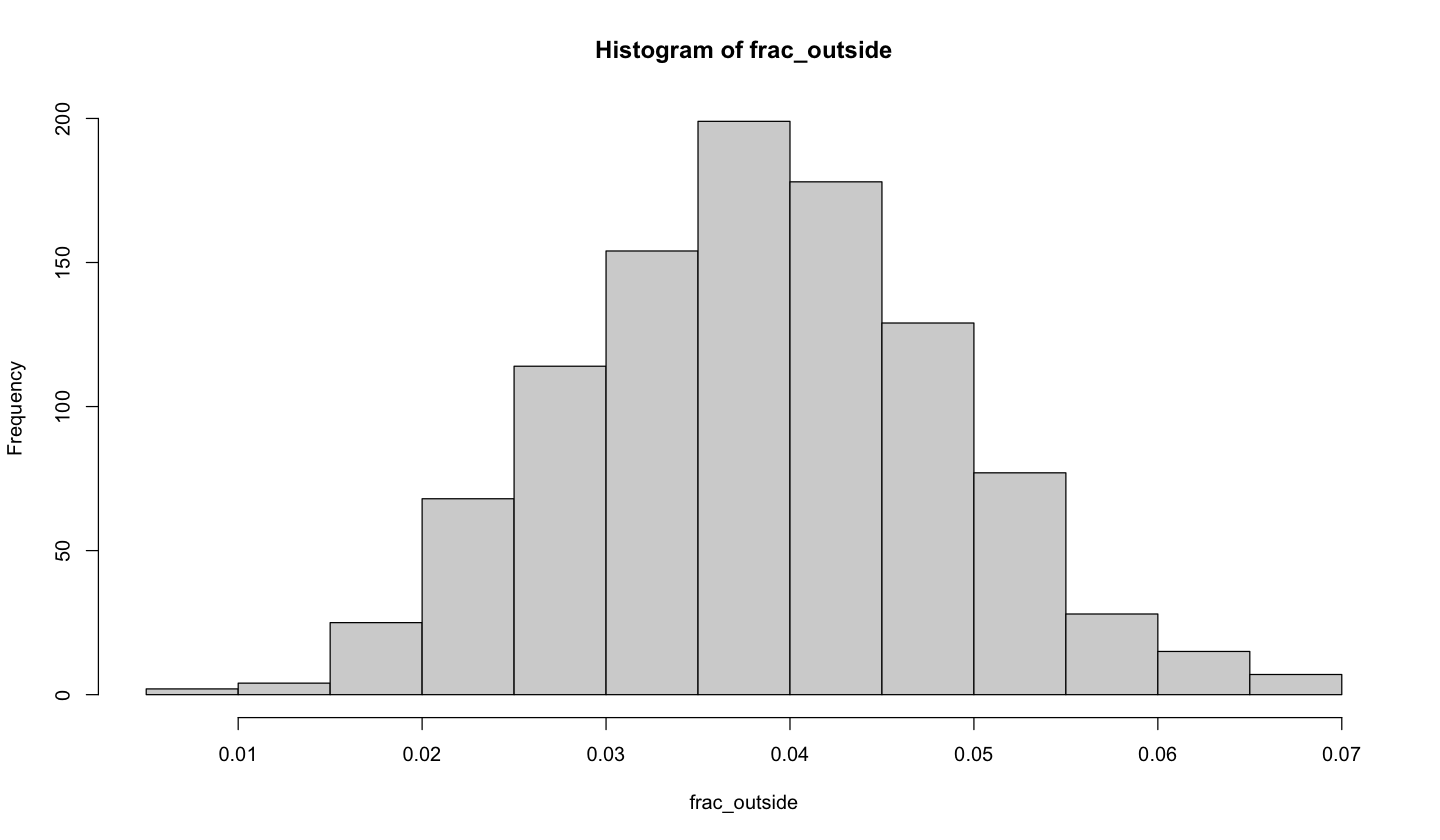

In [398]:
# How to calculate significance:
# We know that the median has an equal number of observations above vs. below the estimate.
# So a null hypothesis would be that each year sees an equal number of observations outside confidence intervals.
# We can resample the residuals (for the training period) and compute the null distribution, then compare 
# each years residuals with this distribution.
# To preserve temporal structure we resample in blocks of 5
block_size = 5
n = dim(train)[1]
B = 1000
frac_outside = rep(0, B)
for (b in 1:B) {
    idx_start = sample(1:(n))[1:floor(n / block_size)]
    idx = idx_start
    for (i in 1:(block_size - 1)) {
        idx = rbind(idx, idx_start + i)
    }
    star = train[pmin(c(idx), rep(n, length(idx))),] # make sure we are inside index limits
    frac_outside[b] = sum(star$centered >= star$centered_high | star$centered <= star$centered_low) / length(c(idx))
}
annual_frac_outside = all %>% group_by(year=year(date)) %>% 
    summarize(frac_outside=sum(centered > centered_high | centered < centered_low) / length(centered),
             frac_over=sum(centered > centered_high) / length(centered))
annual_frac_outside
hist(frac_outside)
abline(v=annual_frac_outside[annual_frac_outside$year==2020,]$frac_outside)
abline(v=annual_frac_outside[annual_frac_outside$year==2021,]$frac_outside)

In [403]:
# Calculate p-values, 2019 is not significant for alpha < 0.027, 2020 and 2021 are both significant.
sum(frac_outside > annual_frac_outside[annual_frac_outside$year==2019,]$frac_outside) / length(frac_outside)
sum(frac_outside > annual_frac_outside[annual_frac_outside$year==2020,]$frac_outside) / length(frac_outside)
sum(frac_outside > annual_frac_outside[annual_frac_outside$year==2021,]$frac_outside) / length(frac_outside)

[1] 0.027

[1] 0

[1] 0

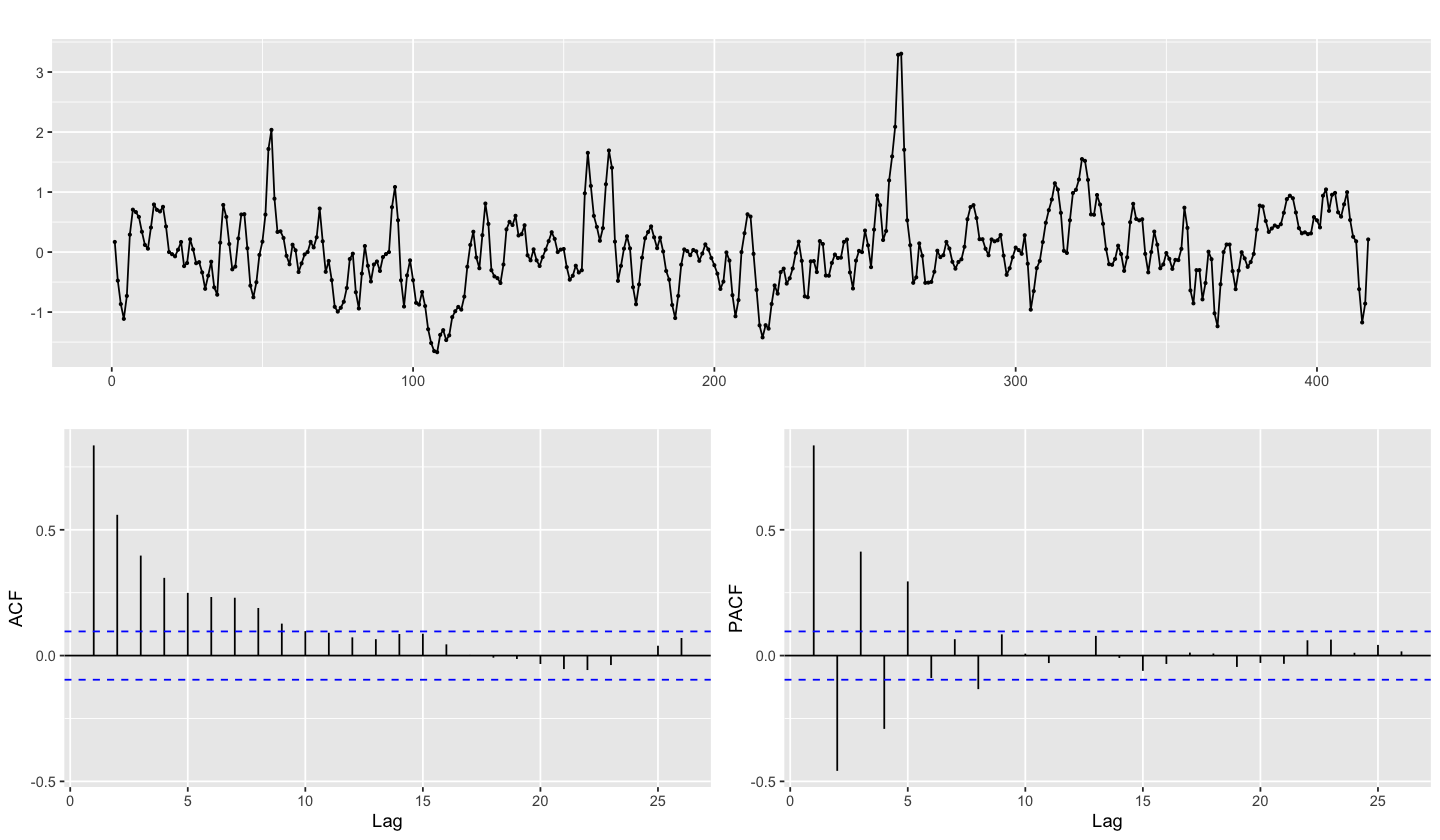

In [404]:
# Appendix A: Arima model on residuals. We see that residuals follow a complex pattern, 
# justifying the block bootstrap
# Fit an ARMA(0,1)
library(forecast)
train$centered %>% ggtsdisplay()

In [412]:
# Read vaccination data
raw = read.csv("../data/2022-02-07.antall-vaksinasjoner-etter-sykdom-fordelt-pa-dag-27.12.2020-05.02.2022.csv", sep=";", skip=1)
# raw = read.csv("../data/2022-02-07.antall-vaksinasjoner-etter-sykdom-fordelt-pa-dag-27.12.2020-05.02.2022.csv")
head(raw)

X          Covid.19..Dose.1..65.74.år Covid.19..Dose.1..75.84.år
1 27.12.2020   5                          0                       
2 28.12.2020  88                        149                       
3 29.12.2020 132                        301                       
4 30.12.2020  66                        123                       
5 31.12.2020   6                         17                       
6 01.01.2021   0                          0                       
  Covid.19..Dose.1..85.og.over Covid.19..Dose.2..65.74.år
1   0                          0                         
2 352                          0                         
3 572                          0                         
4 163                          0                         
5  23                          0                         
6   0                          0                         
  Covid.19..Dose.2..75.84.år Covid.19..Dose.2..85.og.over
1 0                          0                           
2 0                          0                           
3 0                          0                           
4 0                          0                           
5 0                          0                           
6 0                          0                           
  Covid.19..Dose.3..65.74.år Covid.19..Dose.3..75.84.år
1 0                          0                         
2 0                          0                         
3 0                          0                         
4 0                          0                         
5 0                          0                         
6 0                          0                         
  Covid.19..Dose.3..85.og.over
1 0                           
2 0                           
3 0                           
4 0                           
5 0                           
6 0

In [453]:
vax = data.frame(date=raw[,1], dose_1=rowSums(raw[,2:4]), dose_2=rowSums(raw[,5:7]), dose_3=rowSums(raw[,8:10]))
vax$date = as.Date(vax$date, format="%d.%m.%Y")
vax_weekly = vax %>% group_by(ISOweek(date)) %>% 
    summarise(dose_1=sum(dose_1), dose_2=sum(dose_2), dose_3=sum(dose_3))

cum_vax_weekly = cbind(ISOweek2date(apply(vax_weekly[,1],1, paste, "1", sep="-")), cumsum(vax_weekly[, 2:4]))
colnames(cum_vax_weekly)[1] = "date"
head(cum_vax_weekly)

date       dose_1 dose_2 dose_3
1 2020-12-21     5      0  0     
2 2020-12-28  1997      0  0     
3 2021-01-04 20966      0  0     
4 2021-01-11 36478      5  0     
5 2021-01-18 51561   1834  0     
6 2021-01-25 72619  19216  0

In [460]:
tail(merge(all, cum_vax_weekly, all.x=TRUE, by="date"))

date       deaths   week days      detrended trend     centered
515 2021-11-22 17.21898 47   7637 days 3.863012  0.7101145 3.152897
516 2021-11-29 17.81883 48   7644 days 4.469005  1.0297762 3.439229
517 2021-12-06 18.26535 49   7651 days 4.921659  1.3516295 3.570030
518 2021-12-13 18.11012 50   7658 days 4.772570  1.6606394 3.111931
519 2021-12-20 17.70434 51   7665 days 4.372922  1.9417708 2.431152
520 2021-12-27 17.49393 52   7672 days 4.168653  2.1799886 1.988664
    centered_high centered_low dose_1 dose_2 dose_3
515 1.418833      -1.061241    938891 933483 465164
516 1.568199      -1.140896    939339 935040 612262
517 1.719736      -1.220797    939870 936529 749475
518 1.863415      -1.299645    940853 938024 832014
519 1.989205      -1.376139    941427 938542 847872
520 2.087078      -1.448978    941609 938731 852444

In [513]:
apply(cum_vax_weekly[,2:4], 2, max)

dose_1 dose_2 dose_3 
943195 941885 882711

Warning message:
“Removed 155 row(s) containing missing values (geom_path).”


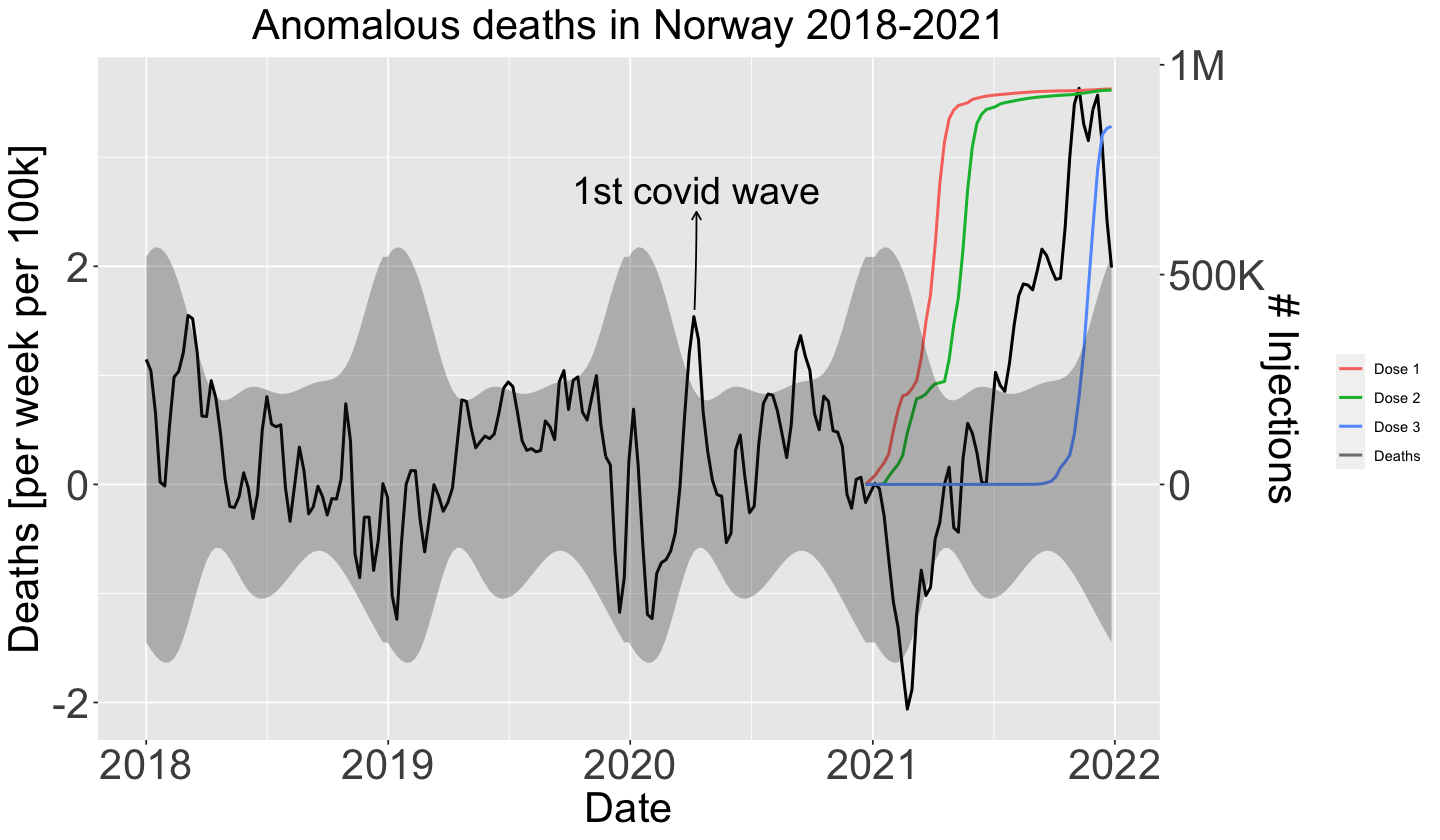

In [588]:
# Superpose vaccination data

# Normalize vax data by max # injections
range = range(all$centered)
max_vax = max(cum_vax_weekly[,2:4])
colmax = apply(cum_vax_weekly[,2:4], 2, function(x) x / max_vax * range[2])
norm_vax = data.frame(date=cum_vax_weekly$date, colmax)
norm_vax = na.omit(norm_vax)
norm_vax = pivot_longer(data.frame(norm_vax), c(2:4), values_to="n_vax", names_to="n_dose")
               
all_vax = merge(all, norm_vax, all.x=TRUE, by="date") %>% distinct()
ggplot(subset(all_vax, year(date) > 2017), aes(date, centered)) + 
geom_line(aes(y=centered), size=0.85) + 
geom_line(aes(y=n_vax, color=n_dose), size=0.85) + 
scale_y_continuous(
    sec.axis=sec_axis(~. * max_vax / range[2], 
                      breaks=c(0, 5e5,1e6),
                    labels = scales::label_number_si(),
name="# Injections")) +
geom_ribbon(aes(ymin=centered_low, ymax=centered_high), alpha=0.3) +
# theme_light() +
labs(x = "Date", y = "Deaths [per week per 100k]", title="Anomalous deaths in Norway 2018-2021") +
theme(plot.title=element_text(size=25, hjust=.5), axis.text=element_text(size=25), axis.title=element_text(size=25))+
scale_color_discrete("", labels=c("Dose 1", "Dose 2", "Dose 3", "Deaths")) + 
annotate(
    geom = "curve", x = as.Date("2020-04-07"), y = 1.6, xend = as.Date("2020-04-10"), yend = 2.5, 
    curvature = .01, arrow = arrow(length = unit(2, "mm"))
  ) +
  annotate(geom = "text", x = as.Date("2020-04-10"), y = 2.7, label = "1st covid wave", hjust = "center", size=8)


In [570]:
?scale_color_discrete

In [204]:
# Fit using weekly median instead
options(repr.plot.width=12, repr.plot.height=7)
train = subset(old_norm,year(date) < 2020 & year(date) > 2010)
all = subset(old_norm,year(date) > 2010)
rq.fit = rq(deaths ~ days, data=train)


sigma = sd(rq.fit$res)
all$detrended = all$deaths - predict(rq.fit, newdata=all)
train$detrended = train$deaths - predict(rq.fit, newdata=train)
rq.fit = rq(detrended ~ pbs(week, df=df), data=train)
summary(rq.fit)
train = merge(train, train %>% group_by(week) %>% summarise(med=median(detrended)), by="week") %>% distinct()
train$


Call: rq(formula = detrended ~ pbs(week, df = df), data = train)

tau: [1] 0.5

Coefficients:
                    Value     Std. Error t value   Pr(>|t|) 
(Intercept)           0.31656   0.05740    5.51496   0.00000
pbs(week, df = df)1  -1.45843   0.10432  -13.98096   0.00000
pbs(week, df = df)2  -1.10731   0.06860  -16.14092   0.00000
pbs(week, df = df)3  -1.09148   0.07304  -14.94415   0.00000
pbs(week, df = df)4  -0.59835   0.07457   -8.02442   0.00000
pbs(week, df = df)5   2.41663   0.12209   19.79423   0.00000
pbs(week, df = df)6   2.28335   0.15065   15.15710   0.00000

week date       deaths   days      detrended med     
1   1    2011-01-03 20.45240 3661 days 3.6789905 2.802988
2   1    2012-01-02 18.87217 4025 days 2.4098425 2.802988
3   1    2012-12-31 20.42055 4389 days 4.2692912 2.802988
4   1    2013-12-30 16.77958 4753 days 0.9393953 2.802988
5   1    2014-12-29 18.72525 5117 days 3.1961338 2.802988
6   1    2016-01-04 17.42054 5488 days 2.2084784 2.802988
7   1    2017-01-02 20.38842 5852 days 5.4874291 2.802988
8   1    2018-01-01 17.92849 6216 days 3.3385711 2.802988
9   1    2018-12-31 16.34387 6580 days 2.0650241 2.802988
10  1    2019-12-30 16.35400 6944 days 2.3862261 2.802988
11  2    2018-01-08 18.00116 6223 days 3.4172307 3.073593
12  2    2017-01-09 20.58350 5859 days 5.6884956 3.073593
13  2    2019-01-07 15.61852 6587 days 1.3456559 3.073593
14  2    2016-01-11 17.91180 5495 days 2.7057206 3.073593
15  2    2014-01-06 16.72571 4760 days 0.8915084 3.073593
16  2    2015-01-05 19.57598 5124 days 4.0528487 3.073593
17  2    2011-01-10 19.84102 3668 days 3.0735926 3.073593
18  2    2013-01-07 19.45030 4396 days 3.3050228 3.073593
19  2    2012-01-09 18.40393 4032 days 1.9475819 3.073593
20  3    2016-01-18 18.34678 5502 days 3.1466891 2.877031
21  3    2017-01-16 19.10297 5866 days 4.2139498 2.877031
22  3    2018-01-15 17.73223 6230 days 3.1542805 2.877031
23  3    2019-01-14 15.52339 6594 days 1.2565113 2.877031
24  3    2015-01-12 19.14420 5131 days 3.6270485 2.877031
25  3    2014-01-13 16.71154 4767 days 0.8833130 2.877031
26  3    2013-01-14 19.01633 4403 days 2.8770312 2.877031
27  3    2012-01-16 18.13307 4039 days 1.6827064 2.877031
28  3    2011-01-17 18.72286 3675 days 1.9614150 2.877031
29  4    2019-01-21 16.28741 6601 days 2.0265106 2.592144
30  4    2018-01-22 17.16411 6237 days 2.5921437 2.592144
⋮   ⋮    ⋮          ⋮        ⋮         ⋮         ⋮       
440 49   2013-12-02 16.41572 4725 days 0.5516042 1.300172
441 49   2012-12-03 17.53318 4361 days 1.3579944 1.300172
442 49   2011-12-05 17.78643 3997 days 1.3001719 1.300172
443 50   2019-12-09 15.02483 6923 days 1.0391132 1.080516
444 50   2018-12-10 15.17328 6559 days 0.8764908 1.080516
445 50   2017-12-11 16.76969 6195 days 2.1618246 1.080516
446 50   2014-12-08 17.01732 5096 days 1.4702563 1.080516
447 50   2016-12-12 17.79459 5831 days 2.8756548 1.080516
448 50   2015-12-07 16.20705 5460 days 0.9710575 1.080516
449 50   2013-12-09 16.68929 4732 days 0.8311537 1.080516
450 50   2012-12-10 18.05671 4368 days 1.8874993 1.080516
451 50   2011-12-12 17.56079 4004 days 1.0805158 1.080516
452 51   2014-12-15 17.17973 5103 days 1.6386479 1.497510
453 51   2016-12-19 18.46870 5838 days 3.5557521 1.497510
454 51   2017-12-18 17.25424 6202 days 2.6523622 1.497510
455 51   2015-12-14 16.13072 5467 days 0.9007107 1.497510
456 51   2018-12-17 15.72098 6566 days 1.4301728 1.497510
457 51   2019-12-16 14.74477 6930 days 0.7650395 1.497510
458 51   2013-12-16 17.17384 4739 days 1.3216896 1.497510
459 51   2012-12-17 18.78263 4375 days 2.6194066 1.497510
460 51   2011-12-19 17.97181 4011 days 1.4975101 1.497510
461 52   2011-12-26 18.75288 4018 days 2.2845659 2.190460
462 52   2015-12-21 16.63222 5474 days 1.4081981 2.190460
463 52   2014-12-22 17.44868 5110 days 1.9135880 2.190460
464 52   2012-12-24 20.10805 4382 days 3.9508044 2.190460
465 52   2013-12-23 17.17209 4746 days 1.3259247 2.190460
466 52   2016-12-26 19.19454 5845 days 4.2875734 2.190460
467 52   2017-12-25 17.66399 6209 days 3.0680946 2.190460
468 52   2018-12-24 16.47528 6573 days 2.1904602 2.190460
469 52   2019-12-23 15.29078 6937 days 1.3170315 2.190460

In [148]:
rq.fit.low = rq(detrended ~ pbs(week, df=df), data=train, tau=0.025)
rq.fit.high = rq(detrended ~ pbs(week, df=df), data=train, tau=0.975)
all$trend = predict(rq.fit, newdata=all)
all$trend_high = predict(rq.fit.high, newdata=all)
all$trend_low = predict(rq.fit.low, newdata=all)
all$centered = all$detrended - all$trend
all$centered_low = all$trend - all$trend_high
all$centered_high = all$trend - all$trend_low
ggplot(subset(all, year(date) > 2018), aes(date, centered)) + 
geom_line(size=1.2) + 
# geom_smooth(aes(x=date, y=centered), stat="identity")
geom_ribbon(aes(ymin=centered_low, ymax=centered_high), alpha=0.3) +
# theme_minimal()
theme(title=element_text(size=20), axis.text=element_text(size=25), axis.title=element_text(size=25)) +
labs(x = "Date", y = "Anomalous Deaths [per week]", title="Anomalous deaths per 100k inhabitants")

In [ ]:
ggplot(old_norm, aes(date, deaths_norm))

In [704]:
age_groups = levels(merged$age)
merged$lnmu_detrended = merged$lnmu
merged$total_days = merged$date - merged$date[1]
cutoff_age = 25
older_age = 64
alpha = 0.0005
for (start_age in unique(merged$start_age[merged$start_age > cutoff_age])) {
    idx = merged$start_age == start_age & merged$year < 2020
    idx_all = merged$start_age == start_age
    age_data = merged[idx,]
    rq.fit = summary(rq(age_data$lnmu ~ age_data$total_days))
    if (dim(rq.fit$coef)[2] == 4) {
        significant = rq.fit$coef[2,4] < alpha
    } else {
        significant = rq.fit$coef[2,2] * rq.fit$coef[2,3] > 0
    }
    if (significant) {
        merged$lnmu_detrended[idx_all] = merged$lnmu[idx_all] - merged$total_days[idx_all] * rq.fit$coef[2,1]
    }
}

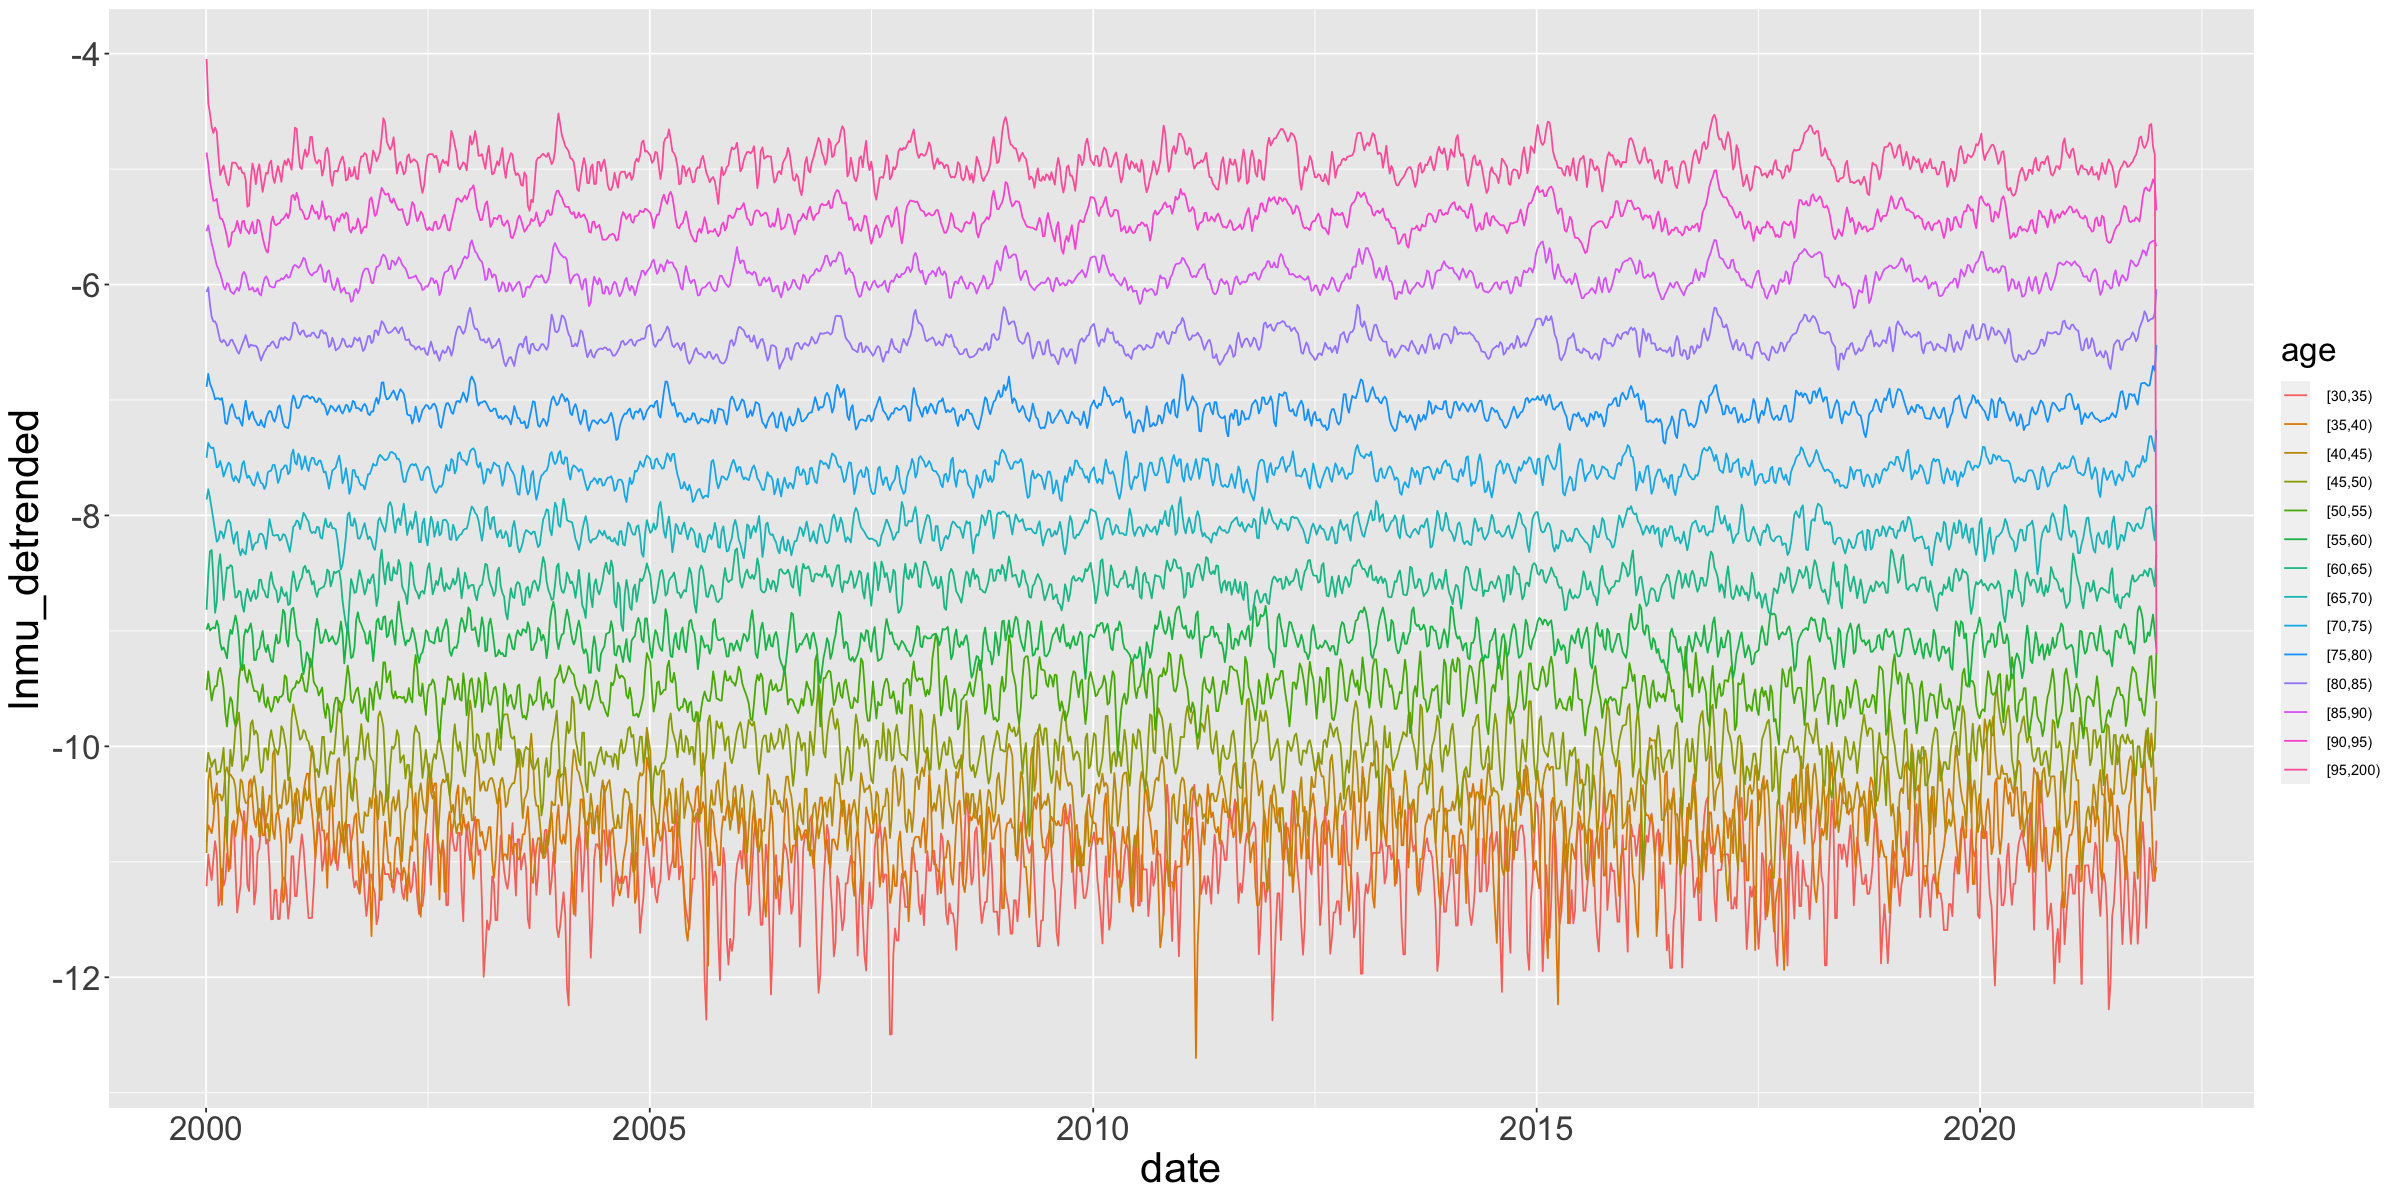

In [705]:
subset = subset(merged, start_age > cutoff_age)
options(repr.plot.width=20, repr.plot.height=10)
n_groups = length(esp_groups)
a = ggplot(subset, aes(x=date, y=lnmu_detrended, color=age))
a + geom_line() +
theme(title=element_text(size=20), axis.text=element_text(size=20), axis.title=element_text(size=25))

In [702]:
seasonal = subset(merged, year < 2020 & year > 2008 & start_age > 44) %>% group_by(week) %>% summarise(avg_lnmu_d = mean(lnmu_detrended))


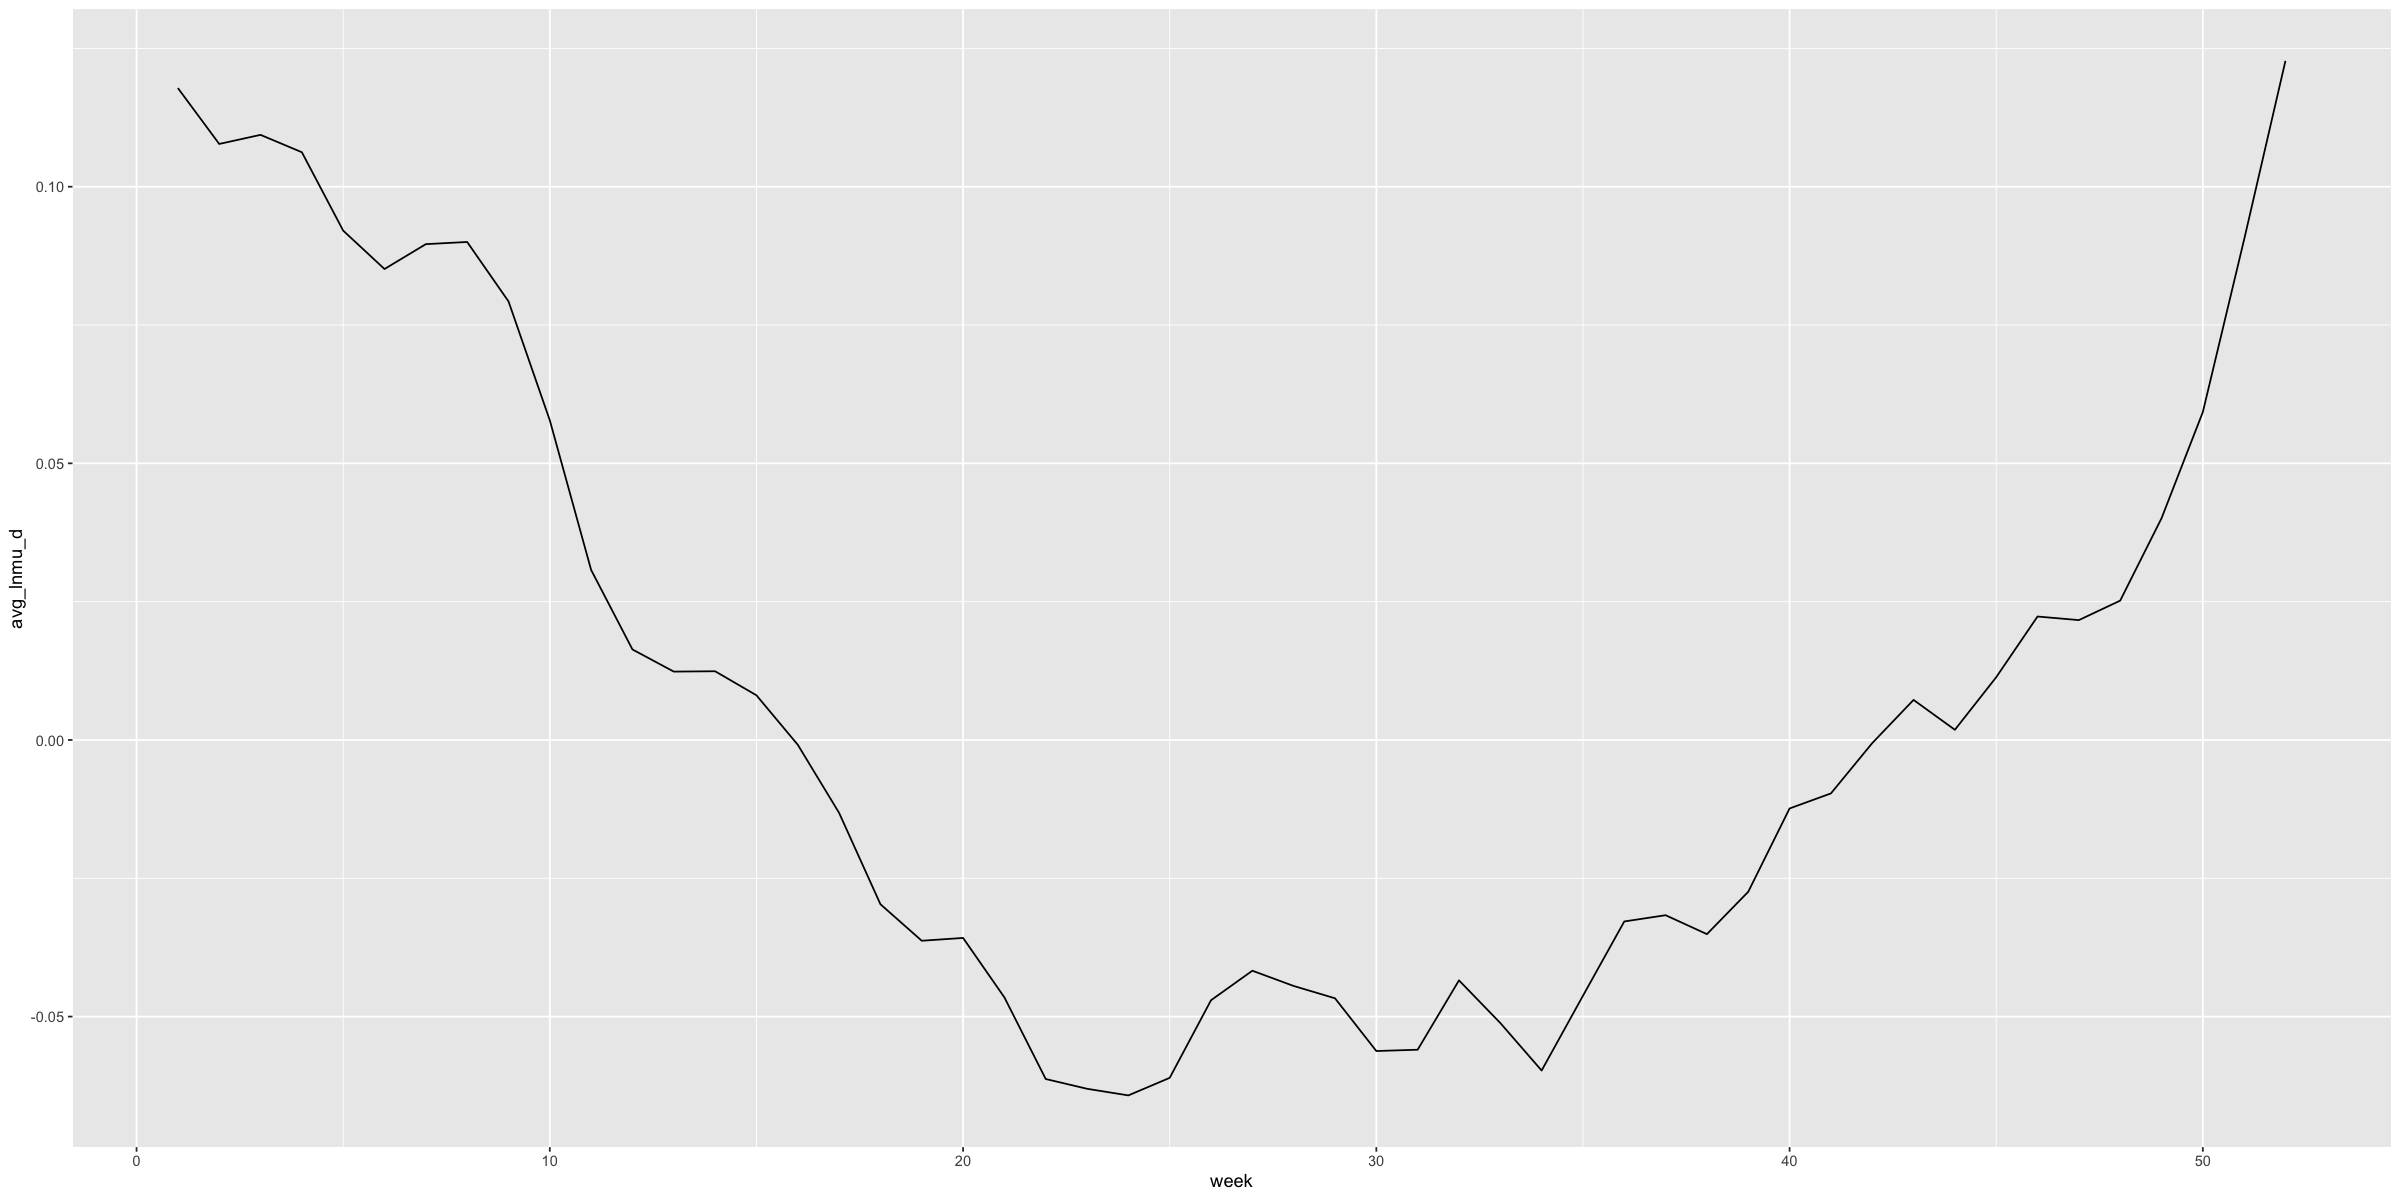

In [703]:
a = ggplot(seasonal, aes(week, avg_lnmu_d))
a + geom_line()

In [788]:
merged_sub = subset(merged, year > 2000 & date !="2021-12-27" & start_age > 64)
y = merged_sub$lnmu

rq.fit = rq(lnmu ~ pbs(week, 6) + age*total_days, data=merged_sub)
summary(rq.fit)


Call: rq(formula = lnmu ~ pbs(week, 6) + age * total_days, data = merged_sub)

tau: [1] 0.5

Coefficients:
                       Value      Std. Error t value    Pr(>|t|)  
(Intercept)              -8.10330    0.00824 -983.36329    0.00000
pbs(week, 6)1            -0.09655    0.01039   -9.29540    0.00000
pbs(week, 6)2            -0.08387    0.00699  -12.00344    0.00000
pbs(week, 6)3            -0.05931    0.00912   -6.50151    0.00000
pbs(week, 6)4            -0.02746    0.00848   -3.23957    0.00120
pbs(week, 6)5             0.14589    0.00723   20.18438    0.00000
pbs(week, 6)6             0.06153    0.01076    5.71635    0.00000
age[70,75)                0.47140    0.00886   53.21562    0.00000
age[75,80)                1.02157    0.00830  123.12702    0.00000
age[80,85)                1.60562    0.00829  193.70018    0.00000
age[85,90)                2.17730    0.00754  288.89291    0.00000
age[90,95)                2.69309    0.00885  304.38520    0.00000
age[95,200)          

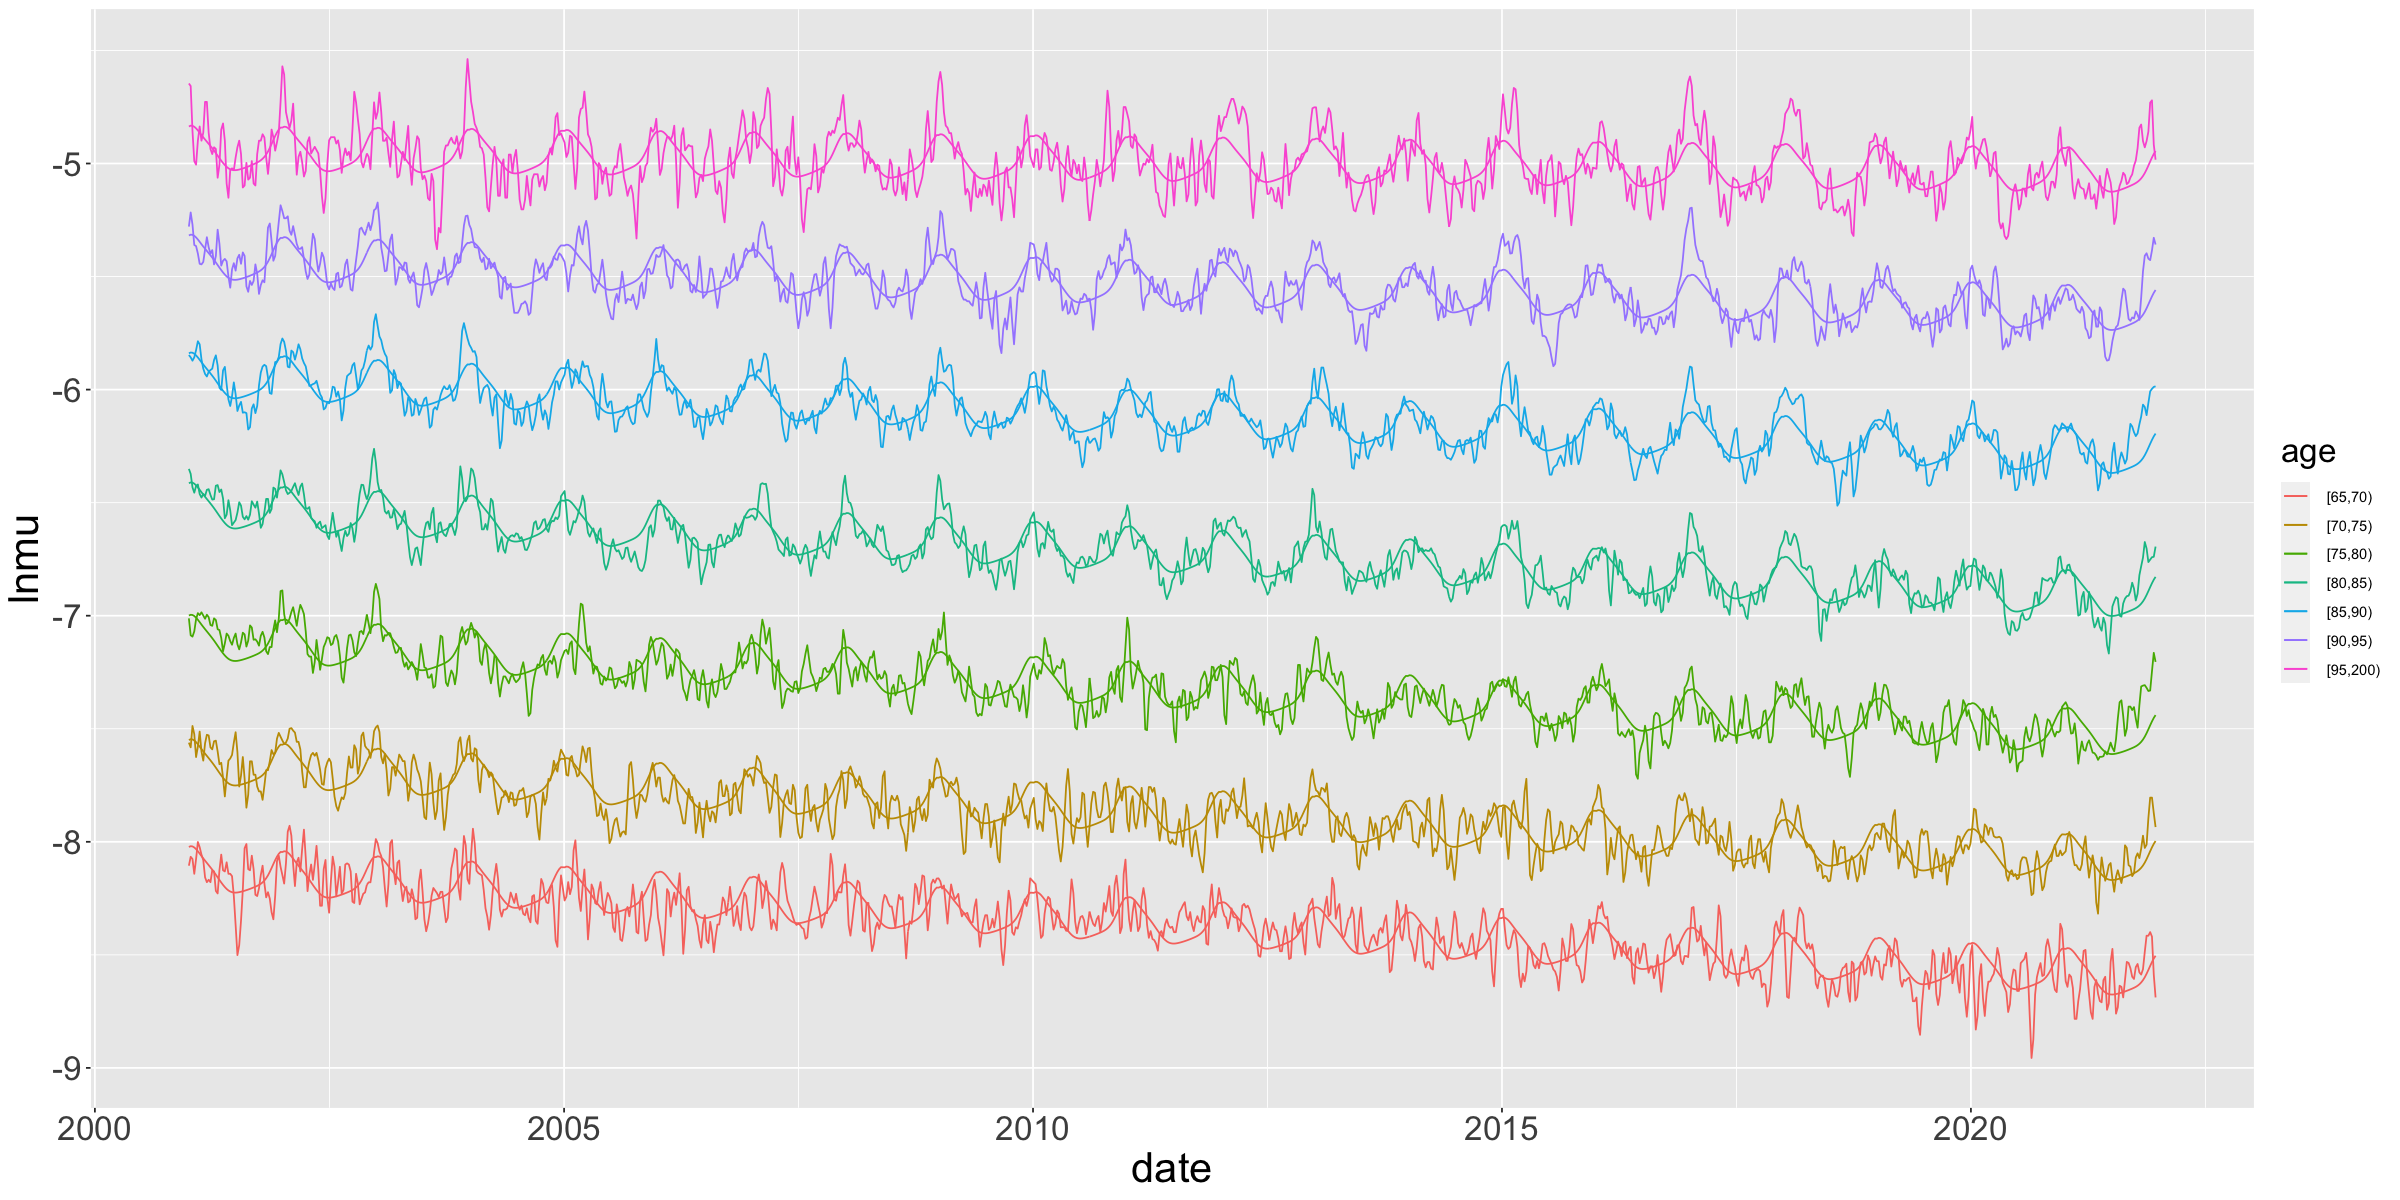

In [789]:
options(repr.plot.width=20, repr.plot.height=10)
n_groups = length(esp_groups)
a = ggplot(merged_sub, aes(x=date, y=lnmu, color=age))
a + geom_line() + geom_line(aes(x=date, y=rq.fit$fitted)) +
theme(title=element_text(size=20), axis.text=element_text(size=20), axis.title=element_text(size=25))

In [790]:
# An easier fit is to sum together mortality 
rq.means = rq(lnmu ~ age + age:total_days, data=merged_sub)
summary(rq.means)


Call: rq(formula = lnmu ~ age + age:total_days, data = merged_sub)

tau: [1] 0.5

Coefficients:
                       Value      Std. Error t value    Pr(>|t|)  
(Intercept)              -8.11647    0.00812 -999.68171    0.00000
age[70,75)                0.48719    0.01328   36.67871    0.00000
age[75,80)                1.03093    0.01137   90.68765    0.00000
age[80,85)                1.60093    0.01085  147.55981    0.00000
age[85,90)                2.17246    0.01249  173.89616    0.00000
age[90,95)                2.70110    0.01256  215.07965    0.00000
age[95,200)               3.18180    0.01352  235.36146    0.00000
age[65,70):total_days    -0.00006    0.00000  -42.09710    0.00000
age[70,75):total_days    -0.00006    0.00000  -31.76305    0.00000
age[75,80):total_days    -0.00006    0.00000  -33.73271    0.00000
age[80,85):total_days    -0.00005    0.00000  -32.85244    0.00000
age[85,90):total_days    -0.00004    0.00000  -23.40519    0.00000
age[90,95):total_days    -0.0000

In [796]:
rq.seasonal.fit = rq(rq.means$res ~ ns(merged_sub$week, 4), tau=c(0.05, 0.5, 0.95))
summary(rq.seasonal.fit)


Call: rq(formula = rq.means$res ~ ns(merged_sub$week, 4), tau = c(0.05, 
    0.5, 0.95))

tau: [1] 0.05

Coefficients:
                        Value     Std. Error t value   Pr(>|t|) 
(Intercept)              -0.03075   0.00917   -3.35180   0.00081
ns(merged_sub$week, 4)1  -0.18579   0.01076  -17.27470   0.00000
ns(merged_sub$week, 4)2  -0.13562   0.01095  -12.38563   0.00000
ns(merged_sub$week, 4)3  -0.11027   0.02252   -4.89587   0.00000
ns(merged_sub$week, 4)4   0.04895   0.01200    4.07889   0.00005

Call: rq(formula = rq.means$res ~ ns(merged_sub$week, 4), tau = c(0.05, 
    0.5, 0.95))

tau: [1] 0.5

Coefficients:
                        Value     Std. Error t value   Pr(>|t|) 
(Intercept)               0.14203   0.00536   26.51849   0.00000
ns(merged_sub$week, 4)1  -0.24017   0.00586  -40.98597   0.00000
ns(merged_sub$week, 4)2  -0.17072   0.00570  -29.96021   0.00000
ns(merged_sub$week, 4)3  -0.18582   0.01277  -14.54709   0.00000
ns(merged_sub$week, 4)4   0.03714   0.00472   

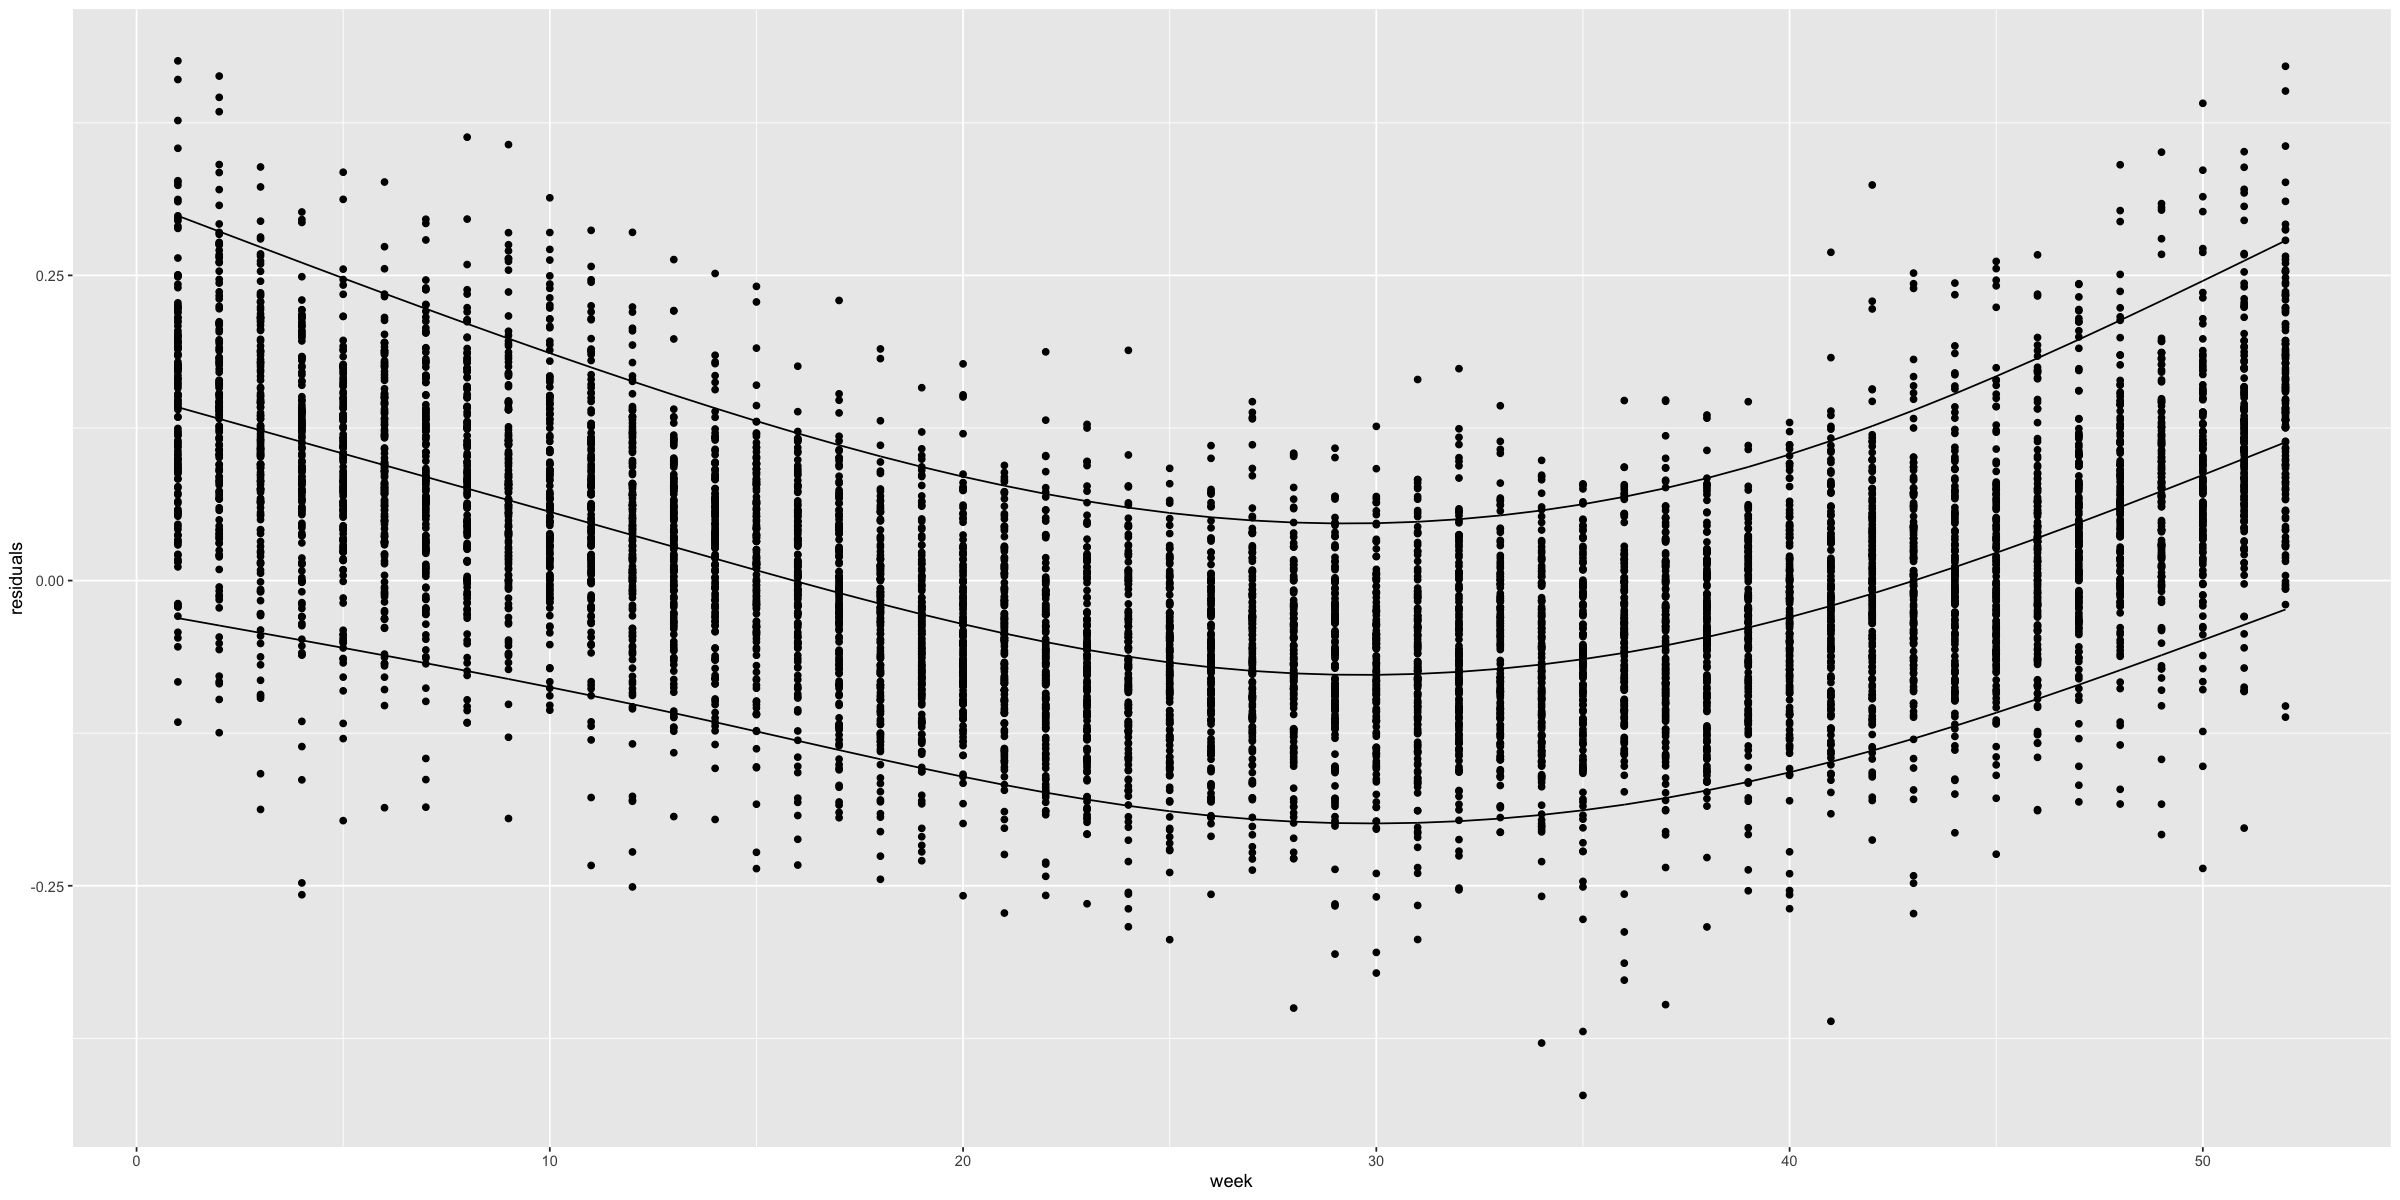

In [812]:
# rq.seasonal.fit[merged_sub$year < 2020,]$res
df = data.frame(week=merged_sub$week, residuals=rq.means$res) 
ggplot(df, aes(week, residuals)) + geom_point() + 
geom_line(aes(x=week, y=rq.seasonal.fit$fit[,2])) +
geom_line(aes(x=week, y=rq.seasonal.fit$fit[,1])) + 
geom_line(aes(x=week, y=rq.seasonal.fit$fit[,3]))

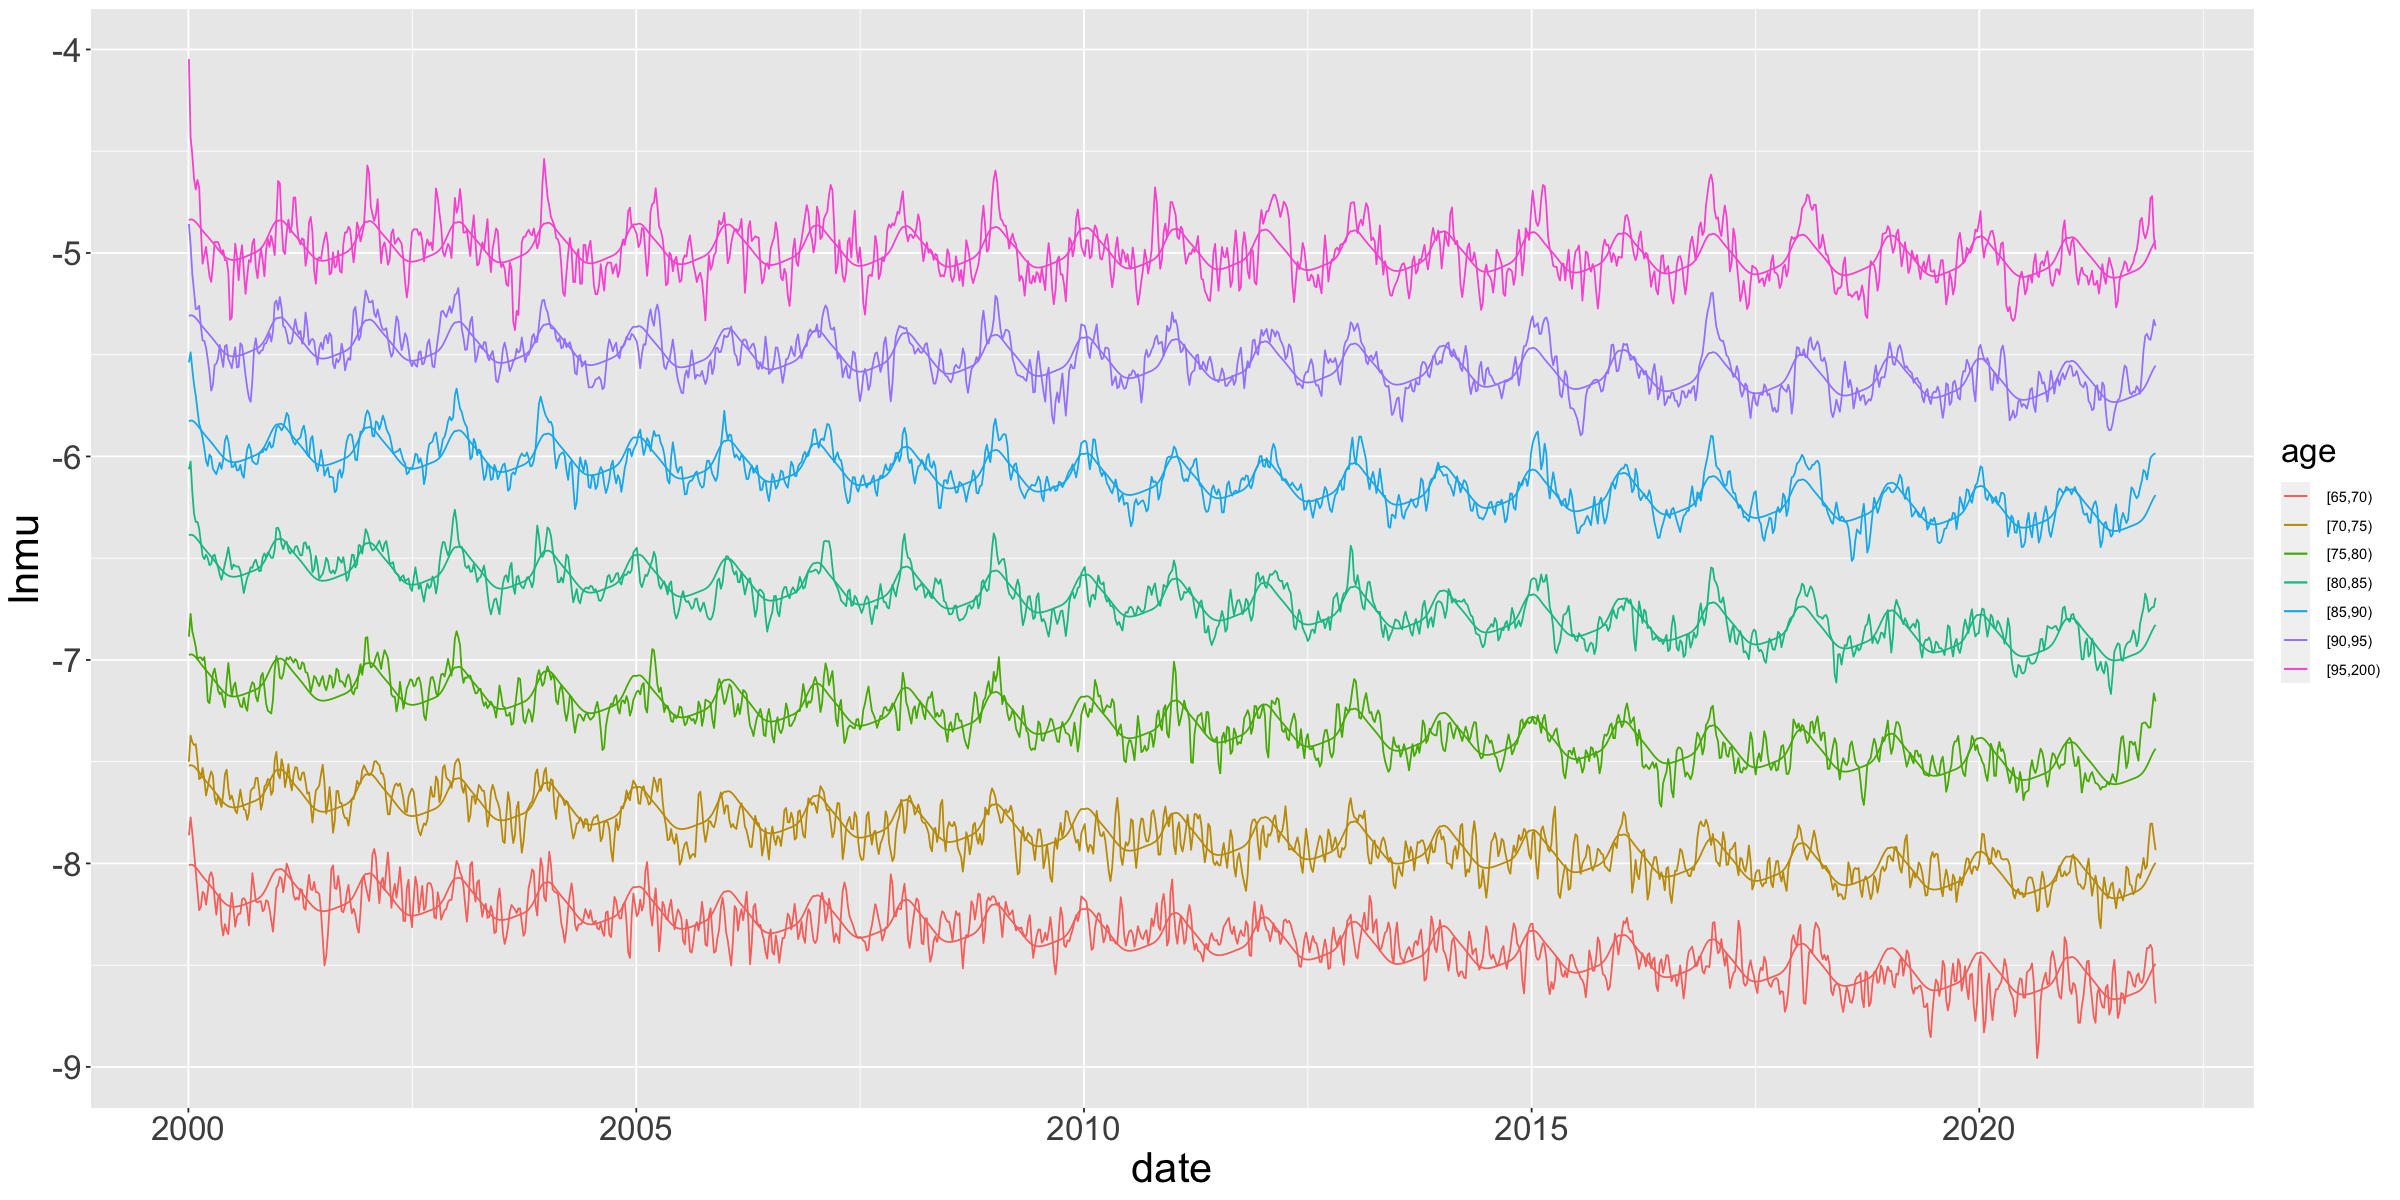

In [780]:
options(repr.plot.width=20, repr.plot.height=10)
n_groups = length(esp_groups)
a = ggplot(merged_sub, aes(x=date, y=lnmu, color=age))
a + geom_line() + geom_line(aes(x=date, y=rq.fit$fitted)) +
theme(title=element_text(size=20), axis.text=element_text(size=20), axis.title=element_text(size=25))

In [764]:
?filter

In [215]:
?element_text